In [1]:
import os
import re

import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib import MatplotlibDeprecationWarning
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from collections import OrderedDict

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, message="Graph is not fully connected")

____

# Načtení dat a první pohled na samotné soubory

Jako první proběhne načtení samotných dat a porovnání, zda jsou obě (klasické záznamy, hashované záznamy) stejné datové sady.

In [3]:
directories_hashed = ['hashed_domain_names/december/','hashed_domain_names/january/', 'hashed_domain_names/february/']
directories_domain = ['regular_domain_names/december/','regular_domain_names/january/', 'regular_domain_names/february/']

**pozn: chybí záznam 5.12.2023** - data z tohoto dne chybí v obou datových sadách.

In [4]:
IPPs = set()
for directory in directories_hashed:
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        if path.endswith('.csv'):
            # print(path)
            df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
            tmp_set = set(df['IP ID'])
            IPPs = IPPs.union(tmp_set)
print(len(IPPs))

4053


In [5]:
print(df.iloc[:,:105].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2003 entries, 0 to 2002
Columns: 105 entries, IP ID to  Occurrence of 9 most regularly visited domain
dtypes: float64(2), int64(103)
memory usage: 1.6 MB
None


In [6]:
def load_IDs(directories):
    # IPs = {key: IP ID, val: [počet výskytů dané IP mezi všemi soubory,[cesty]]}
    IPs = {}
    for directory in directories:
        for file in os.listdir(directory):
            path = os.path.join(directory, file)
            if path.endswith('.csv'):
                # print(path)
                df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
                for ID in df['IP ID']:
                    val = IPs.get(ID)
                    if val:
                        val[0] += 1
                        val[1].append(path)
                    else:
                        IPs[ID] = [1, [path]]
    return IPs

In [7]:
# for hashed
IPs_hashed = load_IDs(directories_hashed)
# for key, val in IPs.items():
    # print(key, val)

In [8]:
IPs_hashed = dict(sorted(IPs_hashed.items(), key=lambda item: (item[1][0], item[0])))
print(len(IPs_hashed))

4053


In [9]:
# for domains
IPs_domains = load_IDs(directories_domain)
# for key, val in IPs_domains.items():
    # print(key, val)

/tmp/ipykernel_50187/1925366488.py:9: ParserWarning: Skipping line 1573: expected 1137 fields, saw 1138

  df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')


warning důvod: záznam pro IP XXX -> `Hour 1 most visited domain 7` X `Hour 1 most visited domain 7 count` => záznamy _\_dns-sd.\_udp.p\\_ a _\215\001_
- cesta/doména rozdělena mezi dva sloupce (chyba, v hashed doménách se nevyskytuje problém)

In [10]:
IPs_domains = dict(sorted(IPs_domains.items(), key=lambda item: (item[1][0], item[0])))
print(len(IPs_domains))

4053


Kontrola, zda data z obou složek sedí.

In [11]:
# check if the results are totaly the same (at least for the number of occurrences and their locations)
print(IPs_hashed.keys() == IPs_domains.keys())
num_occurr = all(IPs_hashed[key][0] == IPs_domains[key][0] for key in IPs_hashed)
print(num_occurr)

for key in IPs_hashed:
    if IPs_hashed[key][0] != IPs_domains[key][0]:
        print(key, IPs_hashed[key][0], IPs_domains[key][0])
# for i in sorted(IPs_domains[2572][1]):
#     print(i)
# print(len(IPs_domains[2572][1]))
# print(len(IPs_hashed[2572][1]))
date_pattern = r"\d{2}-[A-Za-z]{3}-\d{4}"
tmp_regular = []
for path in IPs_hashed[2572][1]:
    match = re.search(date_pattern, path)
    if match:
        date = match.group()
        tmp_regular.append(date)


for i in tmp_regular:
    inList = False
    for path in IPs_domains[2572][1]:
        if i in path:
            inList = True
            break
    if not inList:
        print(i)

True
False
2572 90 89
20-Jan-2024


IP ID trpící na problém identifikovaný výše je 2572. Přes špatný formát v souboru s klasikými doménami nebyl záznam načten, což vyústilo v nestrovnalost.

In [12]:
dftmp = pd.read_csv('regular_domain_names/january/20-Jan-2024_dns_names.csv', delimiter=';', on_bad_lines='warn')

/tmp/ipykernel_50187/1530511858.py:1: ParserWarning: Skipping line 1573: expected 1137 fields, saw 1138

  dftmp = pd.read_csv('regular_domain_names/january/20-Jan-2024_dns_names.csv', delimiter=';', on_bad_lines='warn')


Kontrola, zda se opravdu jedná o soubor 20-Jan-2024: Jelikož je oddělovačem znak `;` a v poslením sloupci daného záznamu se nachází `null;0`, program si myslel, že má řádek o jeden sloupec víc (což formálně kvůli rozdělenému záznamu jinde skutečně má). V hashovaných datech se tento problém nevyskytuje.
\
\
\
Abychom byli schopni identifikovat uživatele s co nejlepší přesností, je pro každého z nich potřeba mít co nejvíce záznamů, v práci tak budeme pracovat s těmi IP adreasami, které se v základu v datech vyskytují v alespoň 80 %.

In [13]:
IPs_by_val = IPs_hashed.copy()
IPs_by_val = dict(sorted(IPs_by_val.items(), key=lambda item: (item[1][0], item[0])))
majority = 0
minority = 0
one_or_two = 0
full_appearance = []
sufficient_appearance = []
IPs_by_val = OrderedDict(reversed(list(IPs_by_val.items())))
for key, val in IPs_by_val.items():
    print(f"{key}:\t{val[0]}".format(key).expandtabs(6))
    # in half of the records or more
    if val[0] >= 72:
        majority += 1
        sufficient_appearance.append(key)
    else:
        minority += 1
    if val[0] == 90:
        full_appearance.append(key)
    if val[0] == 1 or val[0] == 2:
        one_or_two += 1

3494: 90
3493: 90
3492: 90
3491: 90
3488: 90
3487: 90
3486: 90
3484: 90
3483: 90
3482: 90
3481: 90
3480: 90
3479: 90
3478: 90
3477: 90
3476: 90
3475: 90
3474: 90
3473: 90
3472: 90
3471: 90
3470: 90
3469: 90
3468: 90
3467: 90
3466: 90
3465: 90
3464: 90
3461: 90
3460: 90
3459: 90
3458: 90
3457: 90
3401: 90
3400: 90
3399: 90
3398: 90
3396: 90
3393: 90
3390: 90
3379: 90
3363: 90
3353: 90
3352: 90
3351: 90
3350: 90
3348: 90
3347: 90
3345: 90
3344: 90
3343: 90
3342: 90
3341: 90
3340: 90
3339: 90
3337: 90
3336: 90
3335: 90
3332: 90
3330: 90
3329: 90
3326: 90
3325: 90
3324: 90
3323: 90
3322: 90
3320: 90
3318: 90
3315: 90
3312: 90
3311: 90
3309: 90
3308: 90
3307: 90
3306: 90
3305: 90
3304: 90
3303: 90
3302: 90
3301: 90
3300: 90
3299: 90
3298: 90
3297: 90
3295: 90
3293: 90
3287: 90
3286: 90
3285: 90
3284: 90
3283: 90
3281: 90
3278: 90
3275: 90
3274: 90
3272: 90
3270: 90
3269: 90
3268: 90
3267: 90
3266: 90
3265: 90
3264: 90
3262: 90
3261: 90
3260: 90
3258: 90
3256: 90
3254: 90
3253: 90
3252: 90
3

In [14]:
print(majority, minority, majority + minority, one_or_two)

1727 2326 4053 1286


In [14]:
# předběžná kontrola celkového počtu záznamů s výskytem v alespoň 72 dnech
cnt = 0
for key, val in IPs_by_val.items():
    if key in sufficient_appearance:
        cnt += val[0]
print(cnt)

153462


Pro porovnání bude zobrazen i počet všech záznamů dohromady

In [15]:
records = 0
filtered_df = pd.DataFrame()
for directory in directories_hashed:
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        if path.endswith('.csv'):
            df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
            records += df.shape[0]

In [16]:
print(f'Počet záznamů v celých datech: {records}\nNevyužito bude {records-cnt} záznamů\nPráce tak využije {(cnt/records)*100:.1f} % záznamů')

Počet záznamů v celých datech: 171623
Nevyužito bude 18161 záznamů
Práce tak využije 89.4 % záznamů


In [17]:
full_df = pd.DataFrame()
for directory in directories_hashed:
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        if path.endswith('.csv'):
            df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
            full_df = (df.copy() if full_df.empty else pd.concat([full_df, df], ignore_index=True))
full_df = full_df.iloc[:, 0:105]

In [18]:
cat_dict = full_df.iloc[:,10:85].sum().to_dict()
val_sum = sum(cat_dict.values())
min_percentage = val_sum * 0.03
filtered_cat_dict = {key: val for key, val in cat_dict.items() if val >= min_percentage}
rest = sum(val for val in cat_dict.values() if val < min_percentage)
filtered_cat_dict = dict(sorted(filtered_cat_dict.items(), key=lambda item: item[1]))

feats = list(filtered_cat_dict.keys())
feats_vals = list(filtered_cat_dict.values())

feats.insert(0,'Ostatní')
feats_vals.insert(0,rest)

for i in range(len(feats)):
    if 'Search Engines' in feats[i]:
        feats[i] = 'Search Engines / ...'
        break

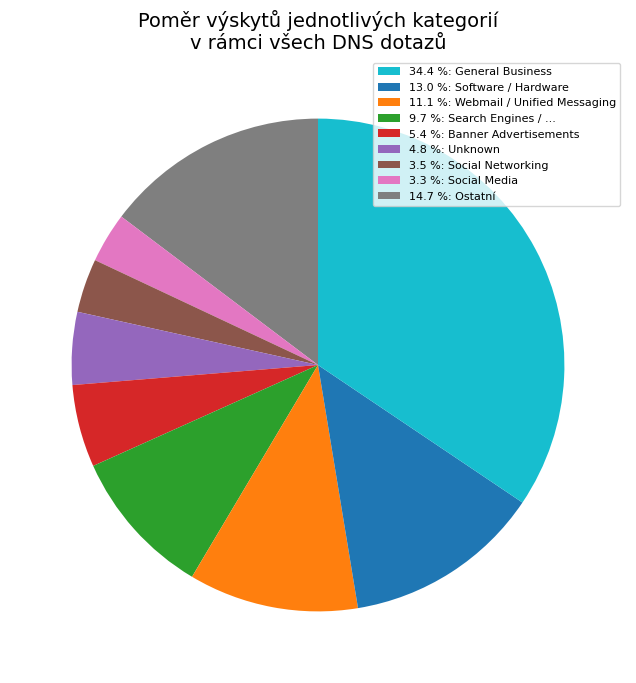

In [19]:
plt.figure(figsize=(15, 8))
shifted_colors = plt.cm.tab10.colors[8:] + plt.cm.tab10.colors[:8]
plt.pie(feats_vals, colors=shifted_colors[::-1], startangle=90)
plt.title('Poměr výskytů jednotlivých kategorií\nv rámci všech DNS dotazů', fontsize=14)
legend_format = [f'{val/val_sum*100:.1f} %: {key}' for key, val in zip(feats, feats_vals)]
plt.legend(labels=legend_format, fontsize=8, loc='upper right', reverse=True)
plt.savefig('images/pie_chart/pie_chart.png', dpi=500, bbox_inches='tight')
plt.show()

Graf rozložení kategorií v rámci všech DNS dotazů.

In [2]:
domains = pd.read_csv('hashed_domain_names/domain_hash_category.csv', delimiter=';', on_bad_lines='warn')

In [5]:
print(f'Unikátních domén celkem: {domains.shape[0]}')
domains['Category of Domain name'].value_counts().head(20)

Unikátních domén celkem: 386218


Category of Domain name
General Business                             135019
Unknown                                      118134
Education                                     12614
Communication Services                        11981
Cloud                                         11419
Banner Advertisements                         11417
Software / Hardware                           11272
Pornography                                   10087
Shopping                                       8372
Computer Games                                 4477
Webmail / Unified Messaging                    4227
News / Magazines                               4172
Search Engines / Web Catalogues / Portals      3930
Sports                                         3690
Fashion / Cosmetics / Jewellery                3372
Blogs / Bulletin Boards                        2695
IT Security / IT Information                   2559
Social Media                                   2482
Travel                                  

____

# Filtrace záznamů #1

Uložení právě pouze těch záznamů, co jsou v datech ve více než 80 %.

In [14]:
# for directory in directories_hashed:
#     for file in os.listdir(directory):
#         path = os.path.join(directory, file)
#         if path.endswith('.csv'):
#             df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
#             filtered_df = df[df['IP ID'].isin(sufficient_appearance)]
#             filtered_df.to_csv('filtered_' + path, sep=';', encoding='utf-8', index=False, header=True)

In [4]:
filtered_directories_hashed = ['filtered_hashed_domain_names/december/', 'filtered_hashed_domain_names/january/', 'filtered_hashed_domain_names/february/']

Budeme také pracovat hlavně se základními příznaky. To kvůli relativně malému počtu záznamů na IP adresu vůči celkové dimenzi dat - 1137 příznaků.

In [3]:
# records = 0
filtered_df = pd.DataFrame()
for directory in filtered_directories_hashed:
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        if path.endswith('.csv'):
            df = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
            filtered_df = (df.copy() if filtered_df.empty else pd.concat([filtered_df, df], ignore_index=True))
            # print(df.shape[0])
            # records += df.shape[0]
filtered_df = filtered_df.iloc[:, 0:105]

In [4]:
print(f"Celkový počet záznamů IP adres, které se vyskytují v >80 % případů: {filtered_df.shape[0]} [počet základních příznaků je {filtered_df.shape[1]}]")

Celkový počet záznamů IP adres, které se vyskytují v >80 % případů: 153462 [počet základních příznaků je 105]


Celkem tak máme 153 462 záznamů z filtrovaných IP adres. Bude však nutné i prozkoumat odlehlé hodnoty, neboli outliery.

In [5]:
# Kontrola unitkátních hodnot (IP ID)
print(len(set(filtered_df['IP ID'])))

1727


1 727 unikátních `IP ID` je správně podle předešlých filtrací.

____

# Konzistence

Způsob, jak zkoumat konzistenci chování uživatelů je nahlédnout na to, jaká je perioda, kdy se uživatelé chovají "agregovaně stejně". Tedy po jaké době je jejich vzorec chování konzistentní. (Viz Fig 1 v článku https://www.sciencedirect.com/science/article/pii/S2352340924003585, ze kterého lze pozorovat, že první tři dny v týdnu bývají nejaktivnější.)

Jelikož se ale v rámci této práce nebude pracovat přímo s časem jako s parametrem (čas nebude brán ohled na čas jako na proměnnou), jedná se v tomto případě spíše o pozorování, které by mohlo být využito v nějaké navazující práci.

(P.S.: Bylo by možné najít takovou periodu, za kterou jsou záznamy konzistentní a poté jednotlivé dny pro všechny IP podle této periody agregovat. Jelikož je ale již takto v základu počet záznamů pro kažkou IP adresu malý, agregace - například po týdnu - by objem dat mohla zmenšit natolik, že by se modely nebyly jednoduše schopné vůbec nic naučit. Nechť je brán ohled i na rozdělení trénovací/validační/testovací množiny. Tedy v extrému, kdy by agregace byla měsíční, musel by být jeden záznam pro trénink, jeden pro validaci a jeden pro testování - to je opravdu nesmyslné.)

ℹ️ V této části se nebere ohled na train-test split, který je na data aplikován v další sekci. Takovýto náhled na celá data bych osobně nevnímal jako tolik problémový. Dokáže nám spíše ukázat, jak dále nad daty přemýšlet. Tato "úvodní analýza" čistě by čistě na trénovacích datech nemusela ukázat tolik co celá data. (Ano, jsem si vědom, že na validační a testovací se správně nemá vůbec sahat, chtěl bych ale zároveň provést určitou analýzu na datech jako celku.)

Později bude na trénovacích datech ještě použita vizualizace pomocí t-SNE, která nám o konzistenci uživatelů dokáže také lecos říct. Jelikož se jedná o již pokročilejší metodu, bude použita až po train test splitu. ℹ️

In [20]:
# random_sel = random.sample(full_appearance, 30)
# random_sel.sort()
# random_sel

In [5]:
random_sel = [91, 148, 184, 441, 463, 464, 482, 872, 876, 938,
              1080, 1211, 1482, 1549, 1993, 2011, 2090, 2263, 2294, 2454,
              2457, 2467, 2591, 2629, 2845, 2851, 3058, 3261, 3350, 3469]

In [6]:
one_day_direct = [[filtered_directories_hashed[0] + '07-Dec-2023_dns.csv', filtered_directories_hashed[0] + '08-Dec-2023_dns.csv'],
                  [filtered_directories_hashed[1] + '10-Jan-2024_dns.csv', filtered_directories_hashed[1] + '11-Jan-2024_dns.csv'],
                  [filtered_directories_hashed[1] + '23-Jan-2024_dns.csv', filtered_directories_hashed[1] + '24-Jan-2024_dns.csv'],
                  [filtered_directories_hashed[2] + '26-Feb-2024_dns.csv', filtered_directories_hashed[2] + '27-Feb-2024_dns.csv']]

one_day_in_week = [[filtered_directories_hashed[0] + '04-Dec-2023_dns.csv', filtered_directories_hashed[0] + '11-Dec-2023_dns.csv'],
                   [filtered_directories_hashed[0] + '13-Dec-2023_dns.csv', filtered_directories_hashed[0] + '20-Dec-2023_dns.csv'],
                   [filtered_directories_hashed[1] + '12-Jan-2024_dns.csv', filtered_directories_hashed[1] + '19-Jan-2024_dns.csv'],
                   [filtered_directories_hashed[2] + '08-Feb-2024_dns.csv', filtered_directories_hashed[2] + '15-Feb-2024_dns.csv']]

three_days = [[[filtered_directories_hashed[0] + '08-Dec-2023_dns.csv', filtered_directories_hashed[0] + '09-Dec-2023_dns.csv', filtered_directories_hashed[0] + '10-Dec-2023_dns.csv'], [filtered_directories_hashed[0] + '11-Dec-2023_dns.csv', filtered_directories_hashed[0] + '12-Dec-2023_dns.csv', filtered_directories_hashed[0] + '13-Dec-2023_dns.csv']],
              [[filtered_directories_hashed[1] + '25-Jan-2024_dns.csv', filtered_directories_hashed[1] + '26-Jan-2024_dns.csv', filtered_directories_hashed[1] + '27-Jan-2024_dns.csv'], [filtered_directories_hashed[1] + '28-Jan-2024_dns.csv', filtered_directories_hashed[1] + '29-Jan-2024_dns.csv', filtered_directories_hashed[1] + '30-Jan-2024_dns.csv']],
              [[filtered_directories_hashed[1] + '15-Jan-2024_dns.csv', filtered_directories_hashed[1] + '16-Jan-2024_dns.csv', filtered_directories_hashed[1] + '17-Jan-2024_dns.csv'], [filtered_directories_hashed[2] + '02-Feb-2024_dns.csv', filtered_directories_hashed[2] + '03-Feb-2024_dns.csv', filtered_directories_hashed[2] + '04-Feb-2024_dns.csv']],
              [[filtered_directories_hashed[2] + '01-Feb-2024_dns.csv', filtered_directories_hashed[2] + '02-Feb-2024_dns.csv', filtered_directories_hashed[2] + '03-Feb-2024_dns.csv'], [filtered_directories_hashed[2] + '25-Feb-2024_dns.csv', filtered_directories_hashed[2] + '26-Feb-2024_dns.csv', filtered_directories_hashed[2] + '27-Feb-2024_dns.csv']]]

five_days = [[[filtered_directories_hashed[0] + '18-Dec-2023_dns.csv', filtered_directories_hashed[0] + '19-Dec-2023_dns.csv', filtered_directories_hashed[0] + '20-Dec-2023_dns.csv', filtered_directories_hashed[0] + '21-Dec-2023_dns.csv', filtered_directories_hashed[0] + '22-Dec-2023_dns.csv'],
              [filtered_directories_hashed[0] + '23-Dec-2023_dns.csv', filtered_directories_hashed[0] + '24-Dec-2023_dns.csv', filtered_directories_hashed[0] + '25-Dec-2023_dns.csv', filtered_directories_hashed[0] + '26-Dec-2023_dns.csv', filtered_directories_hashed[0] + '27-Dec-2023_dns.csv']],
    
             [[filtered_directories_hashed[1] + '05-Jan-2024_dns.csv', filtered_directories_hashed[1] + '06-Jan-2024_dns.csv', filtered_directories_hashed[1] + '07-Jan-2024_dns.csv', filtered_directories_hashed[1] + '08-Jan-2024_dns.csv', filtered_directories_hashed[1] + '09-Jan-2024_dns.csv'],
              [filtered_directories_hashed[1] + '10-Jan-2024_dns.csv', filtered_directories_hashed[1] + '11-Jan-2024_dns.csv', filtered_directories_hashed[1] + '12-Jan-2024_dns.csv', filtered_directories_hashed[1] + '13-Jan-2024_dns.csv', filtered_directories_hashed[1] + '14-Jan-2024_dns.csv']],
    
             [[filtered_directories_hashed[1] + '20-Jan-2024_dns.csv', filtered_directories_hashed[1] + '21-Jan-2024_dns.csv', filtered_directories_hashed[1] + '22-Jan-2024_dns.csv', filtered_directories_hashed[1] + '23-Jan-2024_dns.csv', filtered_directories_hashed[1] + '24-Jan-2024_dns.csv'],
              [filtered_directories_hashed[1] + '31-Jan-2024_dns.csv', filtered_directories_hashed[2] + '01-Feb-2024_dns.csv', filtered_directories_hashed[2] + '02-Feb-2024_dns.csv', filtered_directories_hashed[2] + '03-Feb-2024_dns.csv', filtered_directories_hashed[2] + '04-Feb-2024_dns.csv']],
    
             [[filtered_directories_hashed[2] + '15-Feb-2024_dns.csv', filtered_directories_hashed[2] + '16-Feb-2024_dns.csv', filtered_directories_hashed[2] + '17-Feb-2024_dns.csv', filtered_directories_hashed[2] + '18-Feb-2024_dns.csv', filtered_directories_hashed[2] + '19-Feb-2024_dns.csv'],
              [filtered_directories_hashed[2] + '20-Feb-2024_dns.csv', filtered_directories_hashed[2] + '21-Feb-2024_dns.csv', filtered_directories_hashed[2] + '22-Feb-2024_dns.csv', filtered_directories_hashed[2] + '23-Feb-2024_dns.csv', filtered_directories_hashed[2] + '24-Feb-2024_dns.csv']]]


week_list = [[filtered_directories_hashed[0] + '11-Dec-2023_dns.csv', filtered_directories_hashed[0] + '12-Dec-2023_dns.csv', filtered_directories_hashed[0] + '13-Dec-2023_dns.csv', 
              filtered_directories_hashed[0] + '14-Dec-2023_dns.csv', filtered_directories_hashed[0] + '15-Dec-2023_dns.csv', filtered_directories_hashed[0] + '16-Dec-2023_dns.csv', 
              filtered_directories_hashed[0] + '17-Dec-2023_dns.csv'],
    
             [filtered_directories_hashed[1] + '01-Jan-2024_dns.csv', filtered_directories_hashed[1] + '02-Jan-2024_dns.csv', filtered_directories_hashed[1] + '03-Jan-2024_dns.csv', 
              filtered_directories_hashed[1] + '04-Jan-2024_dns.csv', filtered_directories_hashed[1] + '05-Jan-2024_dns.csv', filtered_directories_hashed[1] + '06-Jan-2024_dns.csv', 
              filtered_directories_hashed[1] + '07-Jan-2024_dns.csv'],
    
             [filtered_directories_hashed[1] + '22-Jan-2024_dns.csv', filtered_directories_hashed[1] + '23-Jan-2024_dns.csv', filtered_directories_hashed[1] + '24-Jan-2024_dns.csv', 
              filtered_directories_hashed[1] + '25-Jan-2024_dns.csv', filtered_directories_hashed[1] + '26-Jan-2024_dns.csv', filtered_directories_hashed[1] + '27-Jan-2024_dns.csv', 
              filtered_directories_hashed[1] + '28-Jan-2024_dns.csv'],
    
             [filtered_directories_hashed[1] + '29-Jan-2024_dns.csv', filtered_directories_hashed[1] + '30-Jan-2024_dns.csv', filtered_directories_hashed[1] + '31-Jan-2024_dns.csv', 
              filtered_directories_hashed[2] + '01-Feb-2024_dns.csv', filtered_directories_hashed[2] + '02-Feb-2024_dns.csv', filtered_directories_hashed[2] + '03-Feb-2024_dns.csv', 
              filtered_directories_hashed[2] + '04-Feb-2024_dns.csv'],
    
             [filtered_directories_hashed[2] + '12-Feb-2024_dns.csv', filtered_directories_hashed[2] + '13-Feb-2024_dns.csv', filtered_directories_hashed[2] + '14-Feb-2024_dns.csv', 
              filtered_directories_hashed[2] + '15-Feb-2024_dns.csv', filtered_directories_hashed[2] + '16-Feb-2024_dns.csv', filtered_directories_hashed[2] + '17-Feb-2024_dns.csv', 
              filtered_directories_hashed[2] + '18-Feb-2024_dns.csv']]

In [7]:
def create_graph(df_concat, idd, border_days, agre, show=False, save=False, folder_name=None):
    fig = plt.figure(figsize=(12, 15), dpi=500)
    X_axis_len = np.arange(len(df_concat.columns))
    
    plt.barh(X_axis_len - 0.2, df_concat.iloc[0], 0.4, color='tomato', label=border_days[0].split("/")[-1][:11])
    plt.barh(X_axis_len + 0.2, df_concat.iloc[1], 0.4, color='royalblue', label=border_days[1].split("/")[-1][:11])
      
    plt.yticks(X_axis_len, df_concat.columns)
    plt.ylabel('Příznaky')
    plt.xlabel('Počet DNS dotazů')
    title = f'Sloupcový graf počtu DNS dotazů pro každou aktivní\n doménovou kategorii pro IP ID {idd} –⁠⁠⁠⁠⁠⁠ '
    if agre == 1:
        title += 'denní'
    elif agre == 3:
        title += 'třídenní agregace'
    elif agre ==5:
        title += 'pětidenní agregace'
    plt.title(title, fontsize=18)
    plt.legend(fontsize=13)
    # plt.tight_layout()
    if save:
        from_to = border_days[0].split("/")[-1][:6].replace('-','_') + '_' + border_days[1].split("/")[-1][:6].replace('-','_')
        save_path = 'images/' + folder_name + '/' + str(idd) + '/' + from_to + '.png'

        dir_name = os.path.dirname(save_path)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    if show:
        plt.show()
    plt.close(fig)

In [8]:
def one_day_graph(id_list, dates, save=False, show=False, folder_name=None) -> None:
    for idd in tqdm(id_list):
        for date_pair in dates:
            data1 = pd.read_csv(date_pair[0], delimiter=';')
            data2 = pd.read_csv(date_pair[1], delimiter=';')

            df_id1 = data1[data1['IP ID'] == idd].iloc[:,list(range(10,85))]
            df_id2 = data2[data2['IP ID'] == idd].iloc[:,list(range(10,85))]

            df_concat = pd.concat([df_id1, df_id2], ignore_index=True)
            df_concat = df_concat.loc[:, (df_concat != 0).any(axis=0)]

            create_graph(df_concat, idd, date_pair, 1, show, save, folder_name)

In [9]:
def three_day_graph(id_list, dates, save=False, show=False, folder_name=None) -> None:
    for idd in tqdm(id_list):
        for date_pair in dates:
            first_three_days = date_pair[0]
            second_three_days = date_pair[1]

            ftd1 = pd.read_csv(first_three_days[0], delimiter=';')
            ftd2 = pd.read_csv(first_three_days[1], delimiter=';')
            ftd3 = pd.read_csv(first_three_days[2], delimiter=';')

            ftd1 = ftd1[ftd1['IP ID'] == idd].iloc[:,list(range(10,85))]
            ftd2 = ftd2[ftd2['IP ID'] == idd].iloc[:,list(range(10,85))]
            ftd3 = ftd3[ftd3['IP ID'] == idd].iloc[:,list(range(10,85))]

            ftd_concat = pd.concat([ftd1, ftd2, ftd3], ignore_index=True)
            ftd_concat = ftd_concat.sum(axis=0)
            ftd_concat = pd.DataFrame([ftd_concat])

            std1 = pd.read_csv(second_three_days[0], delimiter=';')
            std2 = pd.read_csv(second_three_days[1], delimiter=';')
            std3 = pd.read_csv(second_three_days[2], delimiter=';')

            std1 = std1[std1['IP ID'] == idd].iloc[:,list(range(10,85))]
            std2 = std2[std2['IP ID'] == idd].iloc[:,list(range(10,85))]
            std3 = std3[std3['IP ID'] == idd].iloc[:,list(range(10,85))]

            std_concat = pd.concat([std1, std2, std3], ignore_index=True)
            std_concat = std_concat.sum(axis=0)
            std_concat = pd.DataFrame([std_concat])

            df_concat = pd.concat([ftd_concat, std_concat], ignore_index=True)
            df_concat = df_concat.loc[:, (df_concat != 0).any(axis=0)]

            create_graph(df_concat, idd, [first_three_days[0], second_three_days[0]], 3, show, save, folder_name)

In [10]:
def five_day_graph(id_list, dates, save=False, show=False, folder_name=None) -> None:
    for idd in tqdm(id_list):
        for date_pair in dates:
            first_five_days = date_pair[0]
            second_five_days = date_pair[1]

            ffd1 = pd.read_csv(first_five_days[0], delimiter=';')
            ffd2 = pd.read_csv(first_five_days[1], delimiter=';')
            ffd3 = pd.read_csv(first_five_days[2], delimiter=';')
            ffd4 = pd.read_csv(first_five_days[3], delimiter=';')
            ffd5 = pd.read_csv(first_five_days[4], delimiter=';')

            ffd1 = ffd1[ffd1['IP ID'] == idd].iloc[:,list(range(10,85))]
            ffd2 = ffd2[ffd2['IP ID'] == idd].iloc[:,list(range(10,85))]
            ffd3 = ffd3[ffd3['IP ID'] == idd].iloc[:,list(range(10,85))]
            ffd4 = ffd4[ffd4['IP ID'] == idd].iloc[:,list(range(10,85))]
            ffd5 = ffd5[ffd5['IP ID'] == idd].iloc[:,list(range(10,85))]

            ffd_concat = pd.concat([ffd1, ffd2, ffd3, ffd4, ffd5], ignore_index=True)
            ffd_concat = ffd_concat.sum(axis=0)
            ffd_concat = pd.DataFrame([ffd_concat])

            sfd1 = pd.read_csv(second_five_days[0], delimiter=';')
            sfd2 = pd.read_csv(second_five_days[1], delimiter=';')
            sfd3 = pd.read_csv(second_five_days[2], delimiter=';')
            sfd4 = pd.read_csv(second_five_days[3], delimiter=';')
            sfd5 = pd.read_csv(second_five_days[4], delimiter=';')

            sfd1 = sfd1[sfd1['IP ID'] == idd].iloc[:,list(range(10,85))]
            sfd2 = sfd2[sfd2['IP ID'] == idd].iloc[:,list(range(10,85))]
            sfd3 = sfd3[sfd3['IP ID'] == idd].iloc[:,list(range(10,85))]
            sfd4 = sfd4[sfd4['IP ID'] == idd].iloc[:,list(range(10,85))]
            sfd5 = sfd5[sfd5['IP ID'] == idd].iloc[:,list(range(10,85))]

            sfd_concat = pd.concat([sfd1, sfd2, sfd3, sfd4, sfd5], ignore_index=True)
            sfd_concat = sfd_concat.sum(axis=0)
            sfd_concat = pd.DataFrame([sfd_concat])

            df_concat = pd.concat([ffd_concat, sfd_concat], ignore_index=True)
            df_concat = df_concat.loc[:, (df_concat != 0).any(axis=0)]

            create_graph(df_concat, idd, [first_five_days[0], second_five_days[0]], 5, show, save, folder_name)

In [11]:
def week_graph(id_list, week_list, save=False, show=False, folder_name=None) -> None:
    for idd in tqdm(id_list):
        summary_df = pd.DataFrame()
        for week in week_list:
            week1 = pd.read_csv(week[0], delimiter=';')
            week2 = pd.read_csv(week[1], delimiter=';')
            week3 = pd.read_csv(week[2], delimiter=';')
            week4 = pd.read_csv(week[3], delimiter=';')
            week5 = pd.read_csv(week[4], delimiter=';')
            week6 = pd.read_csv(week[5], delimiter=';')
            week7 = pd.read_csv(week[6], delimiter=';')

            week1 = week1[week1['IP ID'] == idd].iloc[:,list(range(10,85))]
            week2 = week2[week2['IP ID'] == idd].iloc[:,list(range(10,85))]
            week3 = week3[week3['IP ID'] == idd].iloc[:,list(range(10,85))]
            week4 = week4[week4['IP ID'] == idd].iloc[:,list(range(10,85))]
            week5 = week5[week5['IP ID'] == idd].iloc[:,list(range(10,85))]
            week6 = week6[week6['IP ID'] == idd].iloc[:,list(range(10,85))]
            week7 = week7[week7['IP ID'] == idd].iloc[:,list(range(10,85))]

            week_concat = pd.concat([week1, week2, week3, week4, week5, week6, week7], ignore_index=True)
            week_concat = week_concat.sum(axis=0)
            week_concat = pd.DataFrame([week_concat])

            summary_df = (week_concat.copy() if summary_df.empty else pd.concat([summary_df, week_concat], ignore_index=True))
        summary_df = summary_df.loc[:, (summary_df != 0).any(axis=0)]

        fig = plt.figure(figsize=(12, 20), dpi=500)
        X_axis_len = np.arange(len(summary_df.columns))
        plt.yticks(X_axis_len * 2, summary_df.columns.tolist())
        
        plt.barh(X_axis_len * 2 - 0.4, summary_df.iloc[0], 0.2, color='tomato', label=week_list[0][0].split("/")[-1][:11])
        plt.barh(X_axis_len * 2 - 0.2, summary_df.iloc[1], 0.2, color='royalblue', label=week_list[1][0].split("/")[-1][:11])
        plt.barh(X_axis_len * 2      , summary_df.iloc[2], 0.2, color='goldenrod', label=week_list[2][0].split("/")[-1][:11])
        plt.barh(X_axis_len * 2 + 0.2, summary_df.iloc[3], 0.2, color='seagreen', label=week_list[3][0].split("/")[-1][:11])
        plt.barh(X_axis_len * 2 + 0.4, summary_df.iloc[4], 0.2, color='mediumorchid', label=week_list[4][0].split("/")[-1][:11])        

        plt.yticks(X_axis_len * 2, summary_df.columns)
        plt.ylabel('Příznaky', fontsize=17)
        plt.xlabel('Počet DNS dotazů', fontsize=17)
        plt.title(f'Sloupcový graf počtu DNS dotazů pro každou aktivní\n doménovou kategorii pro IP ID {idd } –⁠⁠⁠⁠⁠⁠ týdenní agregace', fontsize=18)
        plt.legend(fontsize=13)
        # plt.tight_layout()
        if save:
            # from_to = border_days[0].split("/")[-1][:6].replace('-','_') + '_' + border_days[1].split("/")[-1][:6].replace('-','_')
            save_path = 'images/' + folder_name + '/' + str(idd) + '.png'
    
            dir_name = os.path.dirname(save_path)
            if not os.path.exists(dir_name):
                os.makedirs(dir_name)
            
            plt.savefig(save_path, dpi=500, bbox_inches='tight')
        if show:
            plt.show()
        plt.close(fig)

In [24]:
def month_graph(id_list, save=False, show=False, folder_name=None) -> None:
    for idd in tqdm(id_list):
        summary_df = pd.DataFrame()
        for month in filtered_directories_hashed:
            # print(month)
            month_concat = pd.DataFrame()
            for day in os.listdir(month):
                path = os.path.join(month, day)
                if path.endswith('.csv'):
                    # print(path)
                    curr_day = pd.read_csv(path, delimiter=';', on_bad_lines='warn')
                    curr_day = curr_day[curr_day['IP ID'] == idd].iloc[:,list(range(10,85))]
                    month_concat = (curr_day.copy() if month_concat.empty else pd.concat([month_concat, curr_day], ignore_index=True))
            month_concat = month_concat.sum(axis=0)
            month_concat = pd.DataFrame([month_concat])
            summary_df = (month_concat.copy() if summary_df.empty else pd.concat([summary_df, month_concat], ignore_index=True))
        summary_df = summary_df.loc[:, (summary_df != 0).any(axis=0)]
        
        # display(summary_df)
        fig = plt.figure(figsize=(12, 20), dpi=500)
        # fig = plt.figure(figsize=(20, 12), dpi=500) # pro prezentaci
        X_axis_len = np.arange(len(summary_df.columns))
        plt.yticks(X_axis_len, summary_df.columns.tolist())
        # plt.xticks(X_axis_len, summary_df.columns.tolist(), rotation=45, ha='right') # pro prezentaci
        
        plt.barh(X_axis_len - 0.3, summary_df.iloc[0], 0.3, color='tomato', label='December 2023')
        plt.barh(X_axis_len      , summary_df.iloc[1], 0.3, color='royalblue', label='January 2024')
        plt.barh(X_axis_len + 0.3, summary_df.iloc[2], 0.3, color='goldenrod', label='February 2024')

        # plt.bar(X_axis_len - 0.3, summary_df.iloc[0], 0.3, color='tomato', label='December 2023') # pro prezentaci
        # plt.bar(X_axis_len      , summary_df.iloc[1], 0.3, color='royalblue', label='January 2024') # pro prezentaci
        # plt.bar(X_axis_len + 0.3, summary_df.iloc[2], 0.3, color='goldenrod', label='February 2024') # pro prezentaci
          
        plt.yticks(X_axis_len, summary_df.columns)
        # plt.xticks(X_axis_len, summary_df.columns) # pro prezentaci
        plt.ylabel('Příznaky', fontsize=17)
        plt.xlabel('Počet DNS dotazů', fontsize=17)
        # plt.xlabel('Příznaky', fontsize=17) # pro prezentaci
        # plt.ylabel('Počet DNS dotazů', fontsize=17) # pro prezentaci
        plt.title(f'Sloupcový graf počtu DNS dotazů pro každou aktivní\n doménovou kategorii pro IP ID {idd} –⁠⁠⁠⁠⁠⁠ měsíční agregace', fontsize=18)
        plt.legend(fontsize=13)
        # plt.tight_layout()
        if save:
            # from_to = border_days[0].split("/")[-1][:6].replace('-','_') + '_' + border_days[1].split("/")[-1][:6].replace('-','_')
            save_path = 'images/' + folder_name + '/' + str(idd) + '.png'
            # save_path = 'images/' + folder_name + '/' + str(idd) + '_prezentace.png' # pro prezentaci
    
            dir_name = os.path.dirname(save_path)
            if not os.path.exists(dir_name):
                os.makedirs(dir_name)
            
            plt.savefig(save_path, dpi=500, bbox_inches='tight')
        if show:
            plt.show()
        plt.close(fig)

In [15]:
# test_id_list = [149]
# test_id_list = [1482]

Grafy budou omezeny na `Daily unique domain count` a příznaky jednotlivých kategorií. Důvodem je redundance vysvětlená později.

In [13]:
# one_day_graph(random_sel, one_day_direct, save=True, folder_name='one_day_direct')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [03:45<00:00,  7.53s/it]


In [12]:
# one_day_graph(random_sel, one_day_in_week, save=True, folder_name='one_day_in_week')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [03:47<00:00,  7.58s/it]


In [11]:
# three_day_graph(random_sel, three_days, save=True, folder_name='three_days')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [04:43<00:00,  9.45s/it]


In [11]:
# five_day_graph(random_sel, five_days, save=True, folder_name='five_days')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [05:47<00:00, 11.58s/it]


In [12]:
week_graph(random_sel, week_list, save=True, folder_name='week')

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [03:18<00:00,  6.63s/it]


In [22]:
month_graph(test_id_list, save=True, folder_name='month')

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Pozorování jsou taková, že větší konzistence je viditelná až u delších časových period (týdnů/měsíců). Je tak otázkou, zda budou jednotlivé dny opravdu dostatečně kvalitní data pro predikci.

______________
# Rozdělení dat na ténovací, validační a testovací

V postupu předzpracování dat je nutné velkou datovou sadu rozdělit na trénovací, validační a testovací množiny.

Následující statistické náhledy a analýzy by tak měly být prováděny pouze na trénovací množině dat, neboť zásah do dat na základě pozorování validačních či testovacích dat je metodickou chybou. (Například u odstraňování odlehlých hodnot - necháváme testovací data stranou, neodstraníme jejich odlehlé hodnoty. V reálné praxi/provozu totiž odlehlé hodnoty čas od času nastanou a schopnost zohlednit to v úspěšnosti modelu je důležitá.)

Tedy rozhodnutí o tranformaci dat, odstranění příznaků, atp. budou prováděny na základě pozorování z trénovacích dat. Validační a testovací data budou následně upraveny tak, aby měly vyhovující tvar a formát shodný s formátem trénovacích dat. Nemají tak vliv na rozohodování o činnostech v předzpracování.

In [7]:
Xdata = filtered_df.drop('IP ID', axis=1)
Ydata = filtered_df['IP ID']
display(Xdata.head())
display(Ydata.head())

,Daily query count,Daily unique domain count,Daily detected query type count,Average daily user activity,Average hourly query count,Highest active hour,Lowest active hour,Max hourly query count,Min hourly query count,Abortion,...,5 most regularly visited domain,Occurrence of 5 most regularly visited domain,6 most regularly visited domain,Occurrence of 6 most regularly visited domain,7 most regularly visited domain,Occurrence of 7 most regularly visited domain,8 most regularly visited domain,Occurrence of 8 most regularly visited domain,9 most regularly visited domain,Occurrence of 9 most regularly visited domain
0,550,47,4,22.0,73.0,0,21,144,2,0,...,1128711745,2,1128712111,2,1128708451,2,2756631767,2,2756631768,2
1,9855,582,4,410.0,916.0,19,21,1723,110,0,...,825361355,16,1638586306,16,1486951986,16,1816161638,16,2383704870,15
2,12477,651,4,519.0,750.0,15,5,1442,59,0,...,1638586306,22,187800050,22,3507850949,21,839079073,20,1084012774,18
3,22506,1194,7,937.0,1375.0,9,4,2255,496,0,...,1598274577,24,3438166080,24,1233723811,23,1433465086,23,1638586306,20
4,26445,1240,4,1101.0,2137.0,12,21,4125,149,0,...,2135133235,23,333981273,23,3302331513,23,1433465086,23,1005249093,18


0    2508
1    3190
2    3361
3     500
4     705
Name: IP ID, dtype: int64

In [8]:
# parametr "stratify" umožní data rozdělit rovnoměrně podle tříd
train_df, valtest_df, Ytrain, Yvaltest = train_test_split(Xdata, Ydata, test_size=0.3, random_state=42, stratify=Ydata)
display(train_df.shape)
display(Ytrain.shape)
display(valtest_df.shape)
display(Yvaltest.shape)

(107423, 104)

(107423,)

(46039, 104)

(46039,)

In [9]:
val_df, test_df, Yval, Ytest = train_test_split(valtest_df, Yvaltest, test_size=0.5, random_state=42, stratify=Yvaltest)
display(val_df.shape)
display(Yval.shape)
display(test_df.shape)
display(Ytest.shape)

(23019, 104)

(23019,)

(23020, 104)

(23020,)

In [10]:
train_df.insert(0, 'IP ID', Ytrain)
val_df.insert(0, 'IP ID', Yval)
test_df.insert(0, 'IP ID', Ytest)

In [11]:
print(len(set(Ytrain)))
print(len(set(Yval)))
print(len(set(Ytest)))

1727
1727
1727


_____
# Kategorické atributy

Převedení kategorických příznaků na správný datový typ. Uvažujeme zde příznaky ` X most regularly visited domain`.

Příznaky, které lze teoreticky také považovat za kategorické, by mohly být `Highest active hour` a `Lowest active hour`. One-hot-encoding by tím ovšem znovu zvýšil dimenzi (řídkými daty), a proto bude lepší ponechat hodiny jako numerické proměnné. 

In [12]:
categorical_features = [' 0 most regularly visited domain', ' 1 most regularly visited domain', ' 2 most regularly visited domain',
                        ' 3 most regularly visited domain', ' 4 most regularly visited domain', ' 5 most regularly visited domain',
                        ' 6 most regularly visited domain', ' 7 most regularly visited domain', ' 8 most regularly visited domain', 
                        ' 9 most regularly visited domain']

In [13]:
for category in categorical_features:
    train_df[category] = train_df[category].astype('category')
    val_df[category] = val_df[category].astype('category')
    test_df[category] = test_df[category].astype('category')

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107423 entries, 4107 to 145966
Columns: 105 entries, IP ID to  Occurrence of 9 most regularly visited domain
dtypes: category(10), float64(2), int64(93)
memory usage: 81.6 MB


Analýza rozmanitosti jednotlivých domén v rámci unikátních IP adres: vypočítáme hodnotu, kolik unikátních domén se v kategorických příznacích průměrně vyskytuje u jedné IP adresy.

In [15]:
avg_visited_domains = []
avg_visited_domains_dic = {}
domains_df = train_df.iloc[:,[0] + list(range(85,105,2))]

for idd in set(train_df['IP ID']):
    dic = domains_df[domains_df['IP ID'] == idd].drop(columns=['IP ID']).nunique().to_dict()
    avg_visited_domains.append(dic)

for col in avg_visited_domains[0].keys():
    avg_visited_domains_dic[col] = np.mean([dic[col] for dic in avg_visited_domains])

for key, val in avg_visited_domains_dic.items():
    print(f"{key}: {val:.2f}")

 0 most regularly visited domain: 5.51
 1 most regularly visited domain: 10.58
 2 most regularly visited domain: 13.15
 3 most regularly visited domain: 14.98
 4 most regularly visited domain: 16.42
 5 most regularly visited domain: 17.51
 6 most regularly visited domain: 19.39
 7 most regularly visited domain: 20.71
 8 most regularly visited domain: 22.17
 9 most regularly visited domain: 23.25


Průměrný počet unikátních domén vyskytujících se na daných (populárních) pozicích je tedy uveden výše. Ukazuje, že každá IP adresa má kruh nejpopulárnějších domén vcelku úzký (viz porovnání 1. a 10. pozice). Nicméně pro nás je velice důležité podívat se na celý prostor, ve kterém se tyto domény nachází.

In [16]:
domains_df.iloc[:,1:].nunique()

0 most regularly visited domain    1210
1 most regularly visited domain    1817
2 most regularly visited domain    2094
3 most regularly visited domain    2375
4 most regularly visited domain    2551
5 most regularly visited domain    2693
6 most regularly visited domain    2885
7 most regularly visited domain    3010
8 most regularly visited domain    3148
9 most regularly visited domain    3261
dtype: int64

Jelikož se jedná o kategorickou proměnnou a v každém příznaku se nacházejí jednotky tisíc unikátních domén, jediné řešení by pro nás bylo one-hot-encoding. To by bylo nutné provést na každý příznak zvášť a vzniklo by nám tak více než 20 000 binárních příznaků, které by zároveň byly extrémně řídké v rámci celého prostoru.

I náhrada domén pouze za jejich kategorie (viz soubor `dataset/hashed_domain_names/domain_hash_category.csv`) by nám dimenzionalitu zvedla o stovky - stále v řídkém prostoru. Navíc, informace o nejnavštěvovanější kategorii se dá lehce vypozorovat z hodnot DNS queries jednotlivých kategorií.

FYI: ...attributes describe the number of visits to a domain with a specific content type. Individual domain types were annotated using IBM's x-force...

Na základě těchto pozorování budou tak tyto příznaky odstraněny, jelikož je zde příliš velký nepoměr mezi:
- počtem dostupných záznamů pro každou IP adresu
- počtem unikátních domén
- malé informační hodnotě, kterou to v datech reprezentuje

In [17]:
train_df = train_df.drop(columns=categorical_features)
val_df = val_df.drop(columns=categorical_features)
test_df = test_df.drop(columns=categorical_features)

In [18]:
train_df.head()

,IP ID,Daily query count,Daily unique domain count,Daily detected query type count,Average daily user activity,Average hourly query count,Highest active hour,Lowest active hour,Max hourly query count,Min hourly query count,...,Occurrence of 0 most regularly visited domain,Occurrence of 1 most regularly visited domain,Occurrence of 2 most regularly visited domain,Occurrence of 3 most regularly visited domain,Occurrence of 4 most regularly visited domain,Occurrence of 5 most regularly visited domain,Occurrence of 6 most regularly visited domain,Occurrence of 7 most regularly visited domain,Occurrence of 8 most regularly visited domain,Occurrence of 9 most regularly visited domain
4107,1148,6327,283,3,263.0,316.0,11,0,560,72,...,15,15,15,15,15,15,15,15,15,15
41052,3054,9694,1078,6,403.0,778.0,9,0,1557,0,...,23,23,23,23,23,22,20,19,18,18
16944,3299,4056,339,3,169.0,292.0,9,4,489,96,...,24,24,24,24,24,24,24,24,24,24
144907,2613,12320,643,6,513.0,750.0,14,20,1338,162,...,24,24,24,24,24,24,24,8,7,7
122892,2919,10332,1139,11,430.0,878.0,7,22,1744,12,...,24,24,21,21,20,19,19,19,17,16


__________

# Základní analýza numerických příznaků

Po těchto prvnotních kategorických úpravách je dobrá i základní analýza numerických příznaků.

In [19]:
pd.set_option('display.max_rows', 110)
train_df.iloc[:,1:].describe(include='all').T.head(105)

,count,mean,std,min,25%,50%,75%,max
Daily query count,107423.0,14697.218370,26424.926998,1.0,2944.0,8625.0,17481.0,4789325.0
Daily unique domain count,107423.0,612.006889,532.332126,1.0,158.0,524.0,935.0,5912.0
Daily detected query type count,107423.0,4.835240,2.639476,1.0,3.0,5.0,6.0,14.0
Average daily user activity,107423.0,611.909656,1101.035183,0.0,122.0,359.0,728.0,199555.0
Average hourly query count,107423.0,976.797446,4617.283002,0.0,238.0,673.0,1328.0,1471586.0
Highest active hour,107423.0,13.783445,6.418800,0.0,9.0,15.0,19.0,23.0
Lowest active hour,107423.0,8.060974,7.205759,0.0,1.0,6.0,14.0,23.0
Max hourly query count,107423.0,1767.874329,9170.251969,1.0,427.0,1246.0,2486.0,2943083.0
Min hourly query count,107423.0,186.196950,528.176197,0.0,0.0,59.0,175.0,9797.0
Abortion,107423.0,0.094356,0.961257,0.0,0.0,0.0,0.0,63.0


In [20]:
int(np.var(train_df['Banking']).round())

282235

Pohled na kvartily ukazuje, že je prostor kategorií řídký - to může být teoreticky problém, ovšem v rámci zachování dostatečného množství informace oproti rozumné dimenzi na kategorie sahat nebude příliš prospěšné.

Porovnáním kvartilů a maximálních hodnot to vypadá, že se v datech budou vyskytovat vzdálení outlieři. Je ovšem otázka, zda se bude jednat o celé IP adresy (tedy, že tyto hodnoty budou příslušet vždy malému a konkrétnímu množství IP adres), nebo zda to jsou náhodné výskyty, které by bylo i lepší z dat odstranit. Tato otázka bude zkoumaná později.

Jednou výjimkou z výše uvedeného je příznak `Botnet Command and Control Server`. Ten má v trénovacích datech pouze nulové hodnoty, tedy je neužitečný. Příznak `Sects` je na tom s maximální hodnotou 2 podobně. I ten tak zanalyzujeme.

In [21]:
print(f'Nenulové hodnoty příznaku Botnet Command and Control Server: {(train_df["Botnet Command and Control Server"] != 0).sum()}')
print(f'Nulové hodnoty příznaku Botnet Command and Control Server: {(train_df["Botnet Command and Control Server"] == 0).sum()}')
print(f'Nenulové hodnoty příznaku Sects: {(train_df["Sects"] != 0).sum()}')
print(f'Nulové hodnoty příznaku Sects: {(train_df["Sects"] == 0).sum()}')

Nenulové hodnoty příznaku Botnet Command and Control Server: 0
Nulové hodnoty příznaku Botnet Command and Control Server: 107423
Nenulové hodnoty příznaku Sects: 1
Nulové hodnoty příznaku Sects: 107422


Tyto dva příznaky mají v trénovacích datech nenulovou hodnotu 0x a 1x. Takto malé množství se ani nedá uvažovat za užitečné, a proto budou oba příznaky z dat odstraněny.

In [22]:
train_df = train_df.drop(columns=['Botnet Command and Control Server', 'Sects'])
val_df = val_df.drop(columns=['Botnet Command and Control Server', 'Sects'])
test_df = test_df.drop(columns=['Botnet Command and Control Server', 'Sects'])

\
\
Nyní bude nutné se zaměřit na příznaky, které jsou (lineární) kombinací jiných příznaků. Těmi jsou jen z popisu datové sady příznaky `Daily query count` = součet všech kategorií, `Average hourly query count` = průměr _Max hourly query count_ a _Min hourly query count_, `Average daily user activity` = _Daily query count_ / 24.

Tyto příznaky jsou tak redundatní, neboť nepřináší žádnou novou informaci, naopak, agregují jiné příznaky, a tedy infomaci ztrácí. Budou tak rovnou odstraněny.

In [23]:
# Kontrola, že se v Daily query count sčítají ostatní kategorie
# Hint from https://stackoverflow.com/questions/22342285/summing-two-columns-in-a-pandas-dataframe
queries_sum = filtered_df.iloc[:,10:85].sum(axis=1)

In [24]:
print((filtered_df['Daily query count'] == queries_sum).all())

True


In [25]:
# Kontrola, že se v Average daily user activity je hodnota z Daily query count podělená 24 (dolní celá část)
print((filtered_df['Daily query count'] // 24 == filtered_df['Average daily user activity'] // 1).all())

True


In [26]:
# Kontrola, že se v Average hourly query count je průměr ze součtu Max hourly query count a Min hourly query count (dolní celá část)
print((filtered_df['Average hourly query count'] == (filtered_df['Max hourly query count'] + filtered_df['Min hourly query count']) // 2).all())

True


`Daily query count` příznak ovšem ještě bude hrát roli při detekci odlehlých hodnot. Jeho hodnoty z trénovací množiny tak budou uloženy a ve správný moment (níže v notebooku) budou znovu použity. To z důvodu, že detekce odlehlých hodnot bude fungovat na základě abnormálních aktivit IP adresy. Jelikož ale různé IP adredsy posílají DNS queries ruzných kategorií, bylo by těžké kontrolovat každou kategorii zvlášť. Bude k tomu tak využit právě shrnující příznak všech denních DNS queries. (Příznak ovšem dále do modelů kvůli redundanci uvažovat nebudeme. Zmíněno jako připomenutí.)

In [27]:
daily_query_count = train_df['Daily query count']

In [28]:
train_df = train_df.drop(columns=['Daily query count', 'Average daily user activity', 'Average hourly query count'])
val_df = val_df.drop(columns=['Daily query count', 'Average daily user activity', 'Average hourly query count'])
test_df = test_df.drop(columns=['Daily query count', 'Average daily user activity', 'Average hourly query count'])

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107423 entries, 4107 to 145966
Data columns (total 90 columns):
 #   Column                                          Non-Null Count   Dtype
---  ------                                          --------------   -----
 0   IP ID                                           107423 non-null  int64
 1   Daily unique domain count                       107423 non-null  int64
 2   Daily detected query type count                 107423 non-null  int64
 3   Highest active hour                             107423 non-null  int64
 4   Lowest active hour                              107423 non-null  int64
 5   Max hourly query count                          107423 non-null  int64
 6   Min hourly query count                          107423 non-null  int64
 7   Abortion                                        107423 non-null  int64
 8   Alcohol                                         107423 non-null  int64
 9   Anonymisation Services                          10

Výše tak lze vidět aktuální stav datové sady.
\
\
\
Bude vhodné se blíže podívat i na příznaky `Highest active hour` a `Lowest active hour` - připomenutí, že se s nimi bude pracovat jako s numerickou hodnotou.

In [30]:
print(train_df['Highest active hour'].value_counts())
print()
print(train_df['Lowest active hour'].value_counts())

Highest active hour
20    8260
19    7838
21    7618
18    6962
17    6589
3     6330
22    5875
16    5699
15    4835
9     4720
8     4612
14    4593
10    4430
12    4102
11    4100
13    3982
0     3415
7     3355
23    3120
6     2384
1     1352
5     1284
2      990
4      978
Name: count, dtype: int64

Lowest active hour
0     19072
1      9717
2      6185
4      5892
5      5051
9      4578
10     4496
3      4412
8      4363
23     4185
15     4162
13     3893
7      3582
6      3388
11     2975
16     2930
18     2915
14     2738
12     2584
22     2512
20     2200
17     2065
19     1923
21     1605
Name: count, dtype: int64


Z pozorování distribuce jednotlivých hodin by se teoreticky dala očekávat záporná korelace těchto dvou příznaků. Takový úsudek vychází z toho, že jsou hodiny v rámci "Highest" a "Lowest" znatelně prohozeny. Navíc ani problém 0 X 23 by zde neměl vadit, neboť noční hodiny (uvažujme 0-6) jsou v top příčkách u "Lowest" hodiny a večerní hodiny (uvažme 18-22) jsou v top příčkách "Highest" hodiny. Tedy čistě na základě těchto dvou výstupů by se mohlo očekávat "čím vyšší je hodina 'Highest', tím nižší je hodina 'Lowest'". Jedná se ale o dosti nadsazené tvrzení, neboť podle něj by se aktivita napříč celým dnem reálně zvyšovala a o půlnoci by musela prudce klesnout (může i nemusí být realita).
\
\
\
Smysl bude mít i analyzovat příznaky `Occurrence of X most regularly visited domain` - zda se například v drtivé většině některého z příznaků nevyskytuje pouze jedna hodnota. Pokud by tento výskyt například převyšoval 80 %, nebo dokonce 90 %, stálo by za úvahu, zda by daný příklad nebyl zbytečný, jelikož nemá příliš malou vypovídající hodnotu. Ano, přišlo by se o pár dat, která se v daném příznaku hodnotou liší. V takovém případě je pak na místě poměřit "trade-off" zjednodušení prostoru/interpretace dat proti ztrátě informace.

FYI: Occurrence of k most regularly visited domain = Represents the total number of hours the domain was seen.

In [31]:
for i in range(80, train_df.shape[1]):
    column = train_df.columns[i]
    percentages = train_df[column].value_counts(normalize=True)*100
    abs_count = train_df[column].value_counts()

    print(column)
    for hour, count in abs_count.items():
        percentage = percentages[hour]
        print(f'Hodina {str(hour).rjust(2)}: {count} ({percentage:.2f}%)')
    print()

 Occurrence of 0 most regularly visited domain
Hodina 24: 70538 (65.66%)
Hodina 23: 3735 (3.48%)
Hodina  2: 3701 (3.45%)
Hodina  4: 2196 (2.04%)
Hodina  3: 2194 (2.04%)
Hodina 21: 2165 (2.02%)
Hodina 10: 1869 (1.74%)
Hodina 22: 1703 (1.59%)
Hodina 19: 1559 (1.45%)
Hodina 17: 1516 (1.41%)
Hodina 18: 1459 (1.36%)
Hodina 16: 1450 (1.35%)
Hodina  1: 1372 (1.28%)
Hodina 20: 1323 (1.23%)
Hodina 14: 1305 (1.21%)
Hodina 15: 1294 (1.20%)
Hodina 13: 1288 (1.20%)
Hodina 12: 1266 (1.18%)
Hodina 11: 1112 (1.04%)
Hodina  9: 1021 (0.95%)
Hodina  8: 978 (0.91%)
Hodina  7: 915 (0.85%)
Hodina  5: 751 (0.70%)
Hodina  6: 713 (0.66%)

 Occurrence of 1 most regularly visited domain
Hodina 24: 51716 (48.14%)
Hodina 23: 8644 (8.05%)
Hodina  2: 3628 (3.38%)
Hodina  0: 3026 (2.82%)
Hodina 22: 2948 (2.74%)
Hodina 21: 2727 (2.54%)
Hodina  3: 2484 (2.31%)
Hodina  4: 2376 (2.21%)
Hodina  1: 2209 (2.06%)
Hodina 10: 2173 (2.02%)
Hodina 20: 2089 (1.94%)
Hodina 19: 2018 (1.88%)
Hodina 17: 2009 (1.87%)
Hodina 16: 1986 (

Výskyt jednotlivých hodnot není v rámci datasetu úplně vyvážený. Data však nejsou ani úplně jednotvárná, a tudíž by měla obsahovat i určité množství informace.
\
\
Na závěr budou vytvořeny histogramy a bar ploty jednotlivých příznaků. Již to napoví možnému pravděpodobnostnímu rozložení příznaků.

In [32]:
not_queries = set(train_df.iloc[:,1:].columns).difference(train_df.iloc[:,[1] + list(range(5,80))].columns)

In [33]:
not_queries

{' Occurrence of 0 most regularly visited domain',
 ' Occurrence of 1 most regularly visited domain',
 ' Occurrence of 2 most regularly visited domain',
 ' Occurrence of 3 most regularly visited domain',
 ' Occurrence of 4 most regularly visited domain',
 ' Occurrence of 5 most regularly visited domain',
 ' Occurrence of 6 most regularly visited domain',
 ' Occurrence of 7 most regularly visited domain',
 ' Occurrence of 8 most regularly visited domain',
 ' Occurrence of 9 most regularly visited domain',
 'Daily detected query type count',
 'Highest active hour',
 'Lowest active hour'}

In [36]:
for i, column in enumerate(train_df.iloc[:,[1] + list(range(5,80))].columns):
    plt.figure(figsize=(10, 6))
    # sns.histplot(data=train_df[column][train_df[column] != 0], bins=100)
    sns.histplot(data=train_df[column], bins=50)
    plt.title(f'Histogram rozložení hodnot příznaku {column}')
    plt.xlabel('Počet DNS dotazů')
    plt.ylabel('Počet výskytů v datech (logaritmické měřítko)')
    plt.yscale('log')

    file_name = column.lower().replace(' ', '_').replace('/', '_')
    save_path = 'images/histograms/' + file_name + '.png'
    
    plt.savefig(save_path, dpi=250, bbox_inches='tight')
    plt.close()

In [98]:
for col in not_queries:
    ax = train_df[col].value_counts().plot(kind='bar')
    plt.title(f'Rozdělení hodnot příznaku {col}', fontsize=9)
    plt.xlabel('Hodnota příznaku', fontsize=8)
    plt.ylabel('Počet výskytů', fontsize=8)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(fontsize=8)
    file_name = col.lower().replace(' ', '_').replace('/', '_')
    save_path = 'images/bar_plots/' + file_name + '.png'
    plt.savefig(save_path, dpi=250, bbox_inches='tight')
    plt.close(fig)

In [75]:
hist_features = ['Daily unique domain count', 'Abortion', 'Cloud', 'General Business', 'Job Search', 'Phishing URLs', 'Sports', 'Travel', 'Web Storage']
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(hist_features):
    axes[i].hist(train_df[feature], bins=25)
    axes[i].set_title(feature, fontsize=11)
    axes[i].set_yscale('log')
fig.suptitle('Histogram rozložení hodnot vybraných příznaků', fontsize=18, y=1.002)
fig.supxlabel('Počet DNS dotazů', y=0.002)
fig.supylabel('Počet výskytů v datech (logaritmické měřítko)', x=0.002)
plt.tight_layout()
plt.savefig('images/histograms/cat_hist_summary.png', dpi=1000, bbox_inches='tight')
plt.close(fig)

_______________
# Test normality příznaků

Další část se bude zabývat rozdělením jednotlivých příznaků a následnou korelací. Tento proces může pomoci při hledání dalších redundantních či nadbytečných příznaků.

ℹ️ Příznaky v sobě mají nulové hodnoty, zejména jednotlivé kategorie. Uživatelé ale nepřistupují na všechny kategorie domén zároveň v rámci jednoho dne. Nejedná se tak o chybějící hodnoty, ale o záznamy s hodnotou 0. ℹ️

In [34]:
for column in train_df.iloc[:,1:].columns:
    # plt.figure(figsize=(5,5))

    # line='r' -> “r” - A regression line is fit; 
    sm.qqplot(train_df[column], line='q', **{'markersize': 3})
    
    plt.title(f'Q-Q Plot příznaku {column}')
    plt.xlabel('Teoretické kvantily')
    plt.ylabel('Výběrové kvantily')
    
    file_name = column.lower().replace(' ', '_').replace('/', '_')
    save_path = 'images/qq_plots/' + file_name + '.png'
    
    plt.savefig(save_path, dpi=350, bbox_inches='tight')
    plt.close()

In [31]:
qq_features = ['Daily unique domain count', 'Min hourly query count', 'Arts / Museums / Theatres', 'Blogs / Bulletin Boards', 'Cloud', 'General Business', 'News / Magazines', 'Shopping', 'Social Networking']
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(qq_features):
    sm.qqplot(train_df[feature], line='q', ax=axes[i], **{'markersize': 3})
    axes[i].set_title(feature, fontsize=11)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
fig.suptitle('Q-Q ploty vybraných příznaků', fontsize=18, y=1.002)
fig.supxlabel('Teoretické kvantily', y=0.002)
fig.supylabel('Výběrové kvantily', x=0.002)
plt.tight_layout()
plt.savefig('images/qq_plots/qq_summary.png', dpi=1000, bbox_inches='tight')
plt.close(fig)

QQ ploty zatím vcelku napovídají, že naše příznaky nemají normální rozdělení, což napovídají i histogrami příznaků. Ověříme testem normality.
\
\
\
V rámci testování normality jednotlivých příznaků se bude na 5% hladině významnosti uvažovat následující nulová a alternativní hypotéza:

$H_0$ = Data příznaku _P_ pochází z normálního rozdělení \
$H_A$ = Neplatí $H_0$

K ověření bude použit Kolmogorovovův-Smirnovův test. To kvůli podezřelým odlehlým hodnotám. Nejčastěji používaný test, Shapirův-Wilkův test, je právě na outliery citlivý a nemusel by tak zde být rozumnou volbou.

In [69]:
def perform_normality_test(data, column):
    _, p_value = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    sample_data = data.sample(1000)
    _, p_value_random_sel = stats.kstest(sample_data, 'norm', args=(np.mean(sample_data), np.std(sample_data)))
    if(p_value < 0.05):
        print('Zamítáme ', end='')
    else:
        print('Nezamítáme ', end='')
    column += '.' * (50 - len(column))
    print(f'nulovou hypotézu pro příznak {column}p-hodnota: {p_value:.10f} [pro náhodných 1 000 záznamů {p_value_random_sel:.20f}]\n')

In [119]:
for column in train_df.columns[1:]:
    perform_normality_test(train_df[column], column)

Zamítáme nulovou hypotézu pro příznak Daily unique domain count.........................p-hodnota: 0.0000000000 [pro náhodných 1 000 záznamů 0.00000000000007624480]

Zamítáme nulovou hypotézu pro příznak Daily detected query type count...................p-hodnota: 0.0000000000 [pro náhodných 1 000 záznamů 0.00000000000000000003]

Zamítáme nulovou hypotézu pro příznak Highest active hour...............................p-hodnota: 0.0000000000 [pro náhodných 1 000 záznamů 0.00000000000000135364]

Zamítáme nulovou hypotézu pro příznak Lowest active hour................................p-hodnota: 0.0000000000 [pro náhodných 1 000 záznamů 0.00000000000002783709]

Zamítáme nulovou hypotézu pro příznak Max hourly query count............................p-hodnota: 0.0000000000 [pro náhodných 1 000 záznamů 0.00000000000000000000]

Zamítáme nulovou hypotézu pro příznak Min hourly query count............................p-hodnota: 0.0000000000 [pro náhodných 1 000 záznamů 0.00000000000000000000]

Zamí

Na základě výsledků statistických testů se silně zamítá hypotéza, že příznaky pochází z normálního rozdělení. Tento fakt bude využit v následující sekci.

___

# Korelace

Analýza korelace jednotlivých příznaků je důležitá část předzpracování dat. Dokáže v datech odhalit vztahy, které mohou být pro budoucí modely strojového učení problémové. Důležité je ovšem zmínit i to, že korelace neznamená nutně problém - v poskytnutých datech se dá například očekávat, že čím víc bude DNS queries (vyšší aktivita uživatele), tím více může být (ale nemusí) unikátních navštívených domén. Oba příznaky však říkají něco jiného a každý nese určitou část informace.

Jelikož poskytnutá data nemají normální rozdělení, nesplňují tak předpoklad pro Pearsonův korelační koeficient - tedy nelze vytvořit korelační matici právě za pomocí tohoto korelačního koeficientu. Je ovšem možné použít neparametrickou alternativu, Spearmanův korelační korelační koeficient. Je otázkou, jak v tomto případě dokáže odhalit v datech určité struktury - má schopnost zachytit i ty nelineární díky práci s "ranky" dat místo jejich reálných hodnot. (V případě stejných hodnot = měly by dostat stejný rank, používá se average ranking, tedy `(rank_a1 + ... + rank_aN) / N`)

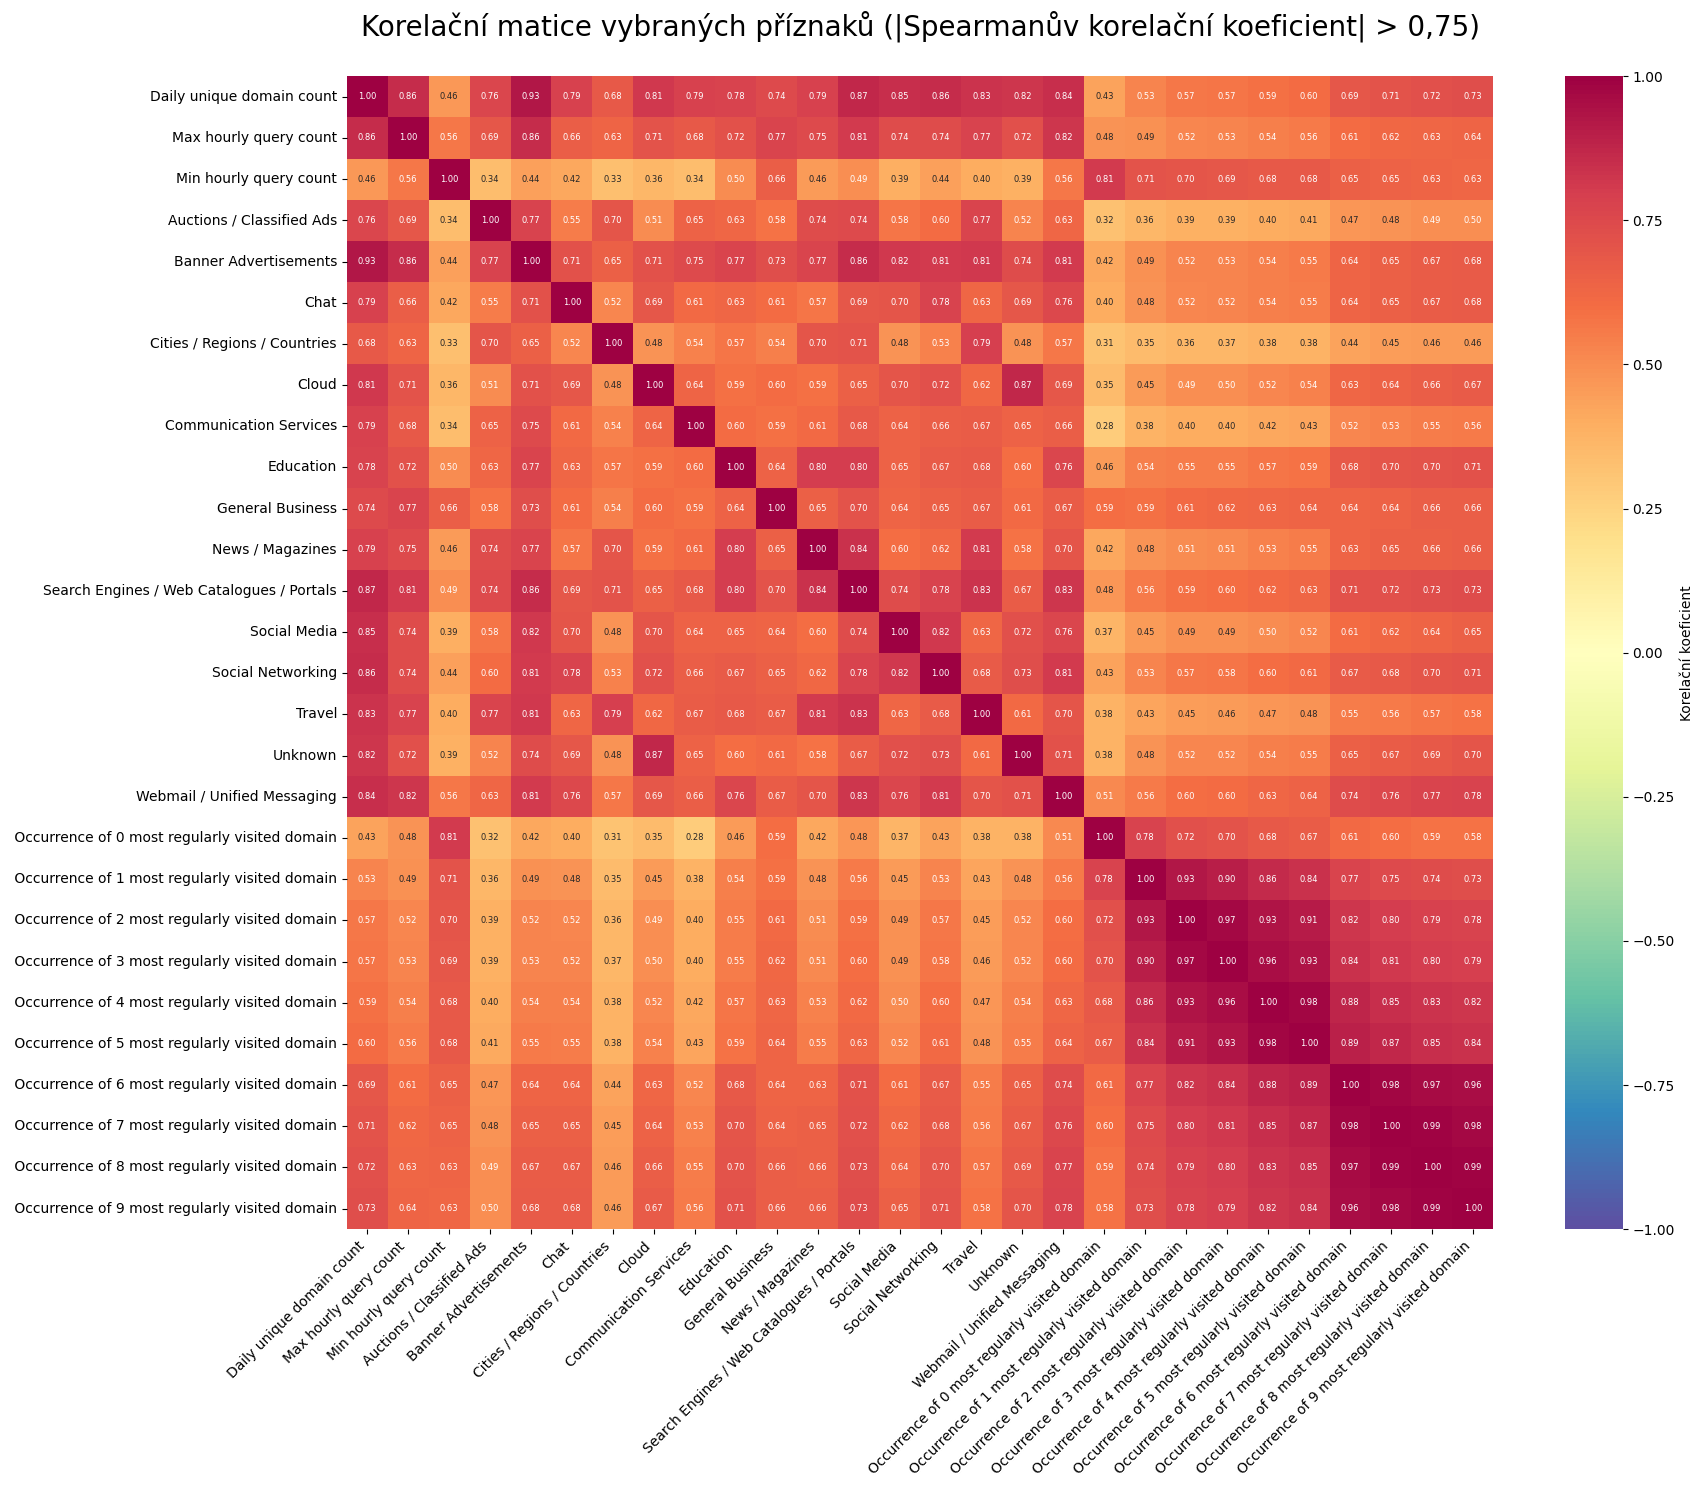

In [32]:
big_corr = train_df.iloc[:,1:].corr(method='spearman')
np.fill_diagonal(big_corr.values, 0)
high_val_cols = big_corr.columns[(big_corr.abs() > 0.75).any()]
big_corr = big_corr.loc[high_val_cols, high_val_cols]
np.fill_diagonal(big_corr.values, 1)

orig_map=plt.colormaps.get_cmap('Spectral')
reversed_map = orig_map.reversed() 

fig, ax = plt.subplots(figsize=(18,15))
sns.heatmap(big_corr, annot=True, cmap=reversed_map, vmin=-1, vmax=1, cbar_kws={'label': 'Korelační koeficient'}, annot_kws={'size': 6}, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.title('Korelační matice vybraných příznaků (|Spearmanův korelační koeficient| > 0,75)\n', fontsize=20)
plt.tight_layout()
plt.savefig('images/correlation/corr_summary.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close(fig)

Výsledná korelační matice poukázala zejména na korelaci příznaků `Occurrence of X most regularly visited domain`. Korelaci příznaků kategorií s `Daily unique domain count` se dá očekávat. Tento případ již byl popsán výše, a proto se daného shrnujícího příznaku nemá smysl zbavovat (opět, velký počet DNS queries nemusí nutně znamenat velké množství navštívených domén).

Žádná jiná extrémní korelace (>0,9) se ale v korelační matici nevyskytuje. Spearmanův korelační koeficient nemusel být na tyto data úplně efektivní. Více informací by mohla sdělit analýza multikolinearity. K tomu bude zkoumán VIF (variance inflation factor), který také dokáže dobře zaznamenat, jak spolu příznaky korelují.

FYI: VIF hodnota 5 bývá označována za hraniční a příznaky s větším VIF je doporučené odstranit, nebo alespoň jeden z páru, který vypadá závisle jeden na druhém. Jindy se jako problémová hodnota VIF uvádí až hodnota 10. Někdy se tak hodnoty mezi 5 a 10 uvažují za mezní a rozhodnutí o ponechání, či odstranění příznaku je primárně na expertovi.

In [37]:
# VIF Python impletementace z https://www.datacamp.com/tutorial/variance-inflation-factor

X = train_df.iloc[:,1:]

# intercept = 1, lepší přizpůsobení regresorům
X = add_constant(X)

VIF = pd.DataFrame()
VIF['Feature'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF['VIF'] = VIF['VIF'].round(2)
# print(VIF)

In [38]:
print(VIF[VIF['VIF'] > 5].iloc[1:])

                                           Feature     VIF
1                        Daily unique domain count    5.86
5                           Max hourly query count   17.81
9                           Anonymisation Services    6.51
24                                  Computer Games   19.60
55                                     Pornography   19.32
65                             Software / Hardware   15.38
81   Occurrence of 1 most regularly visited domain   12.06
82   Occurrence of 2 most regularly visited domain   45.98
83   Occurrence of 3 most regularly visited domain   58.67
84   Occurrence of 4 most regularly visited domain   62.66
85   Occurrence of 5 most regularly visited domain   42.84
86   Occurrence of 6 most regularly visited domain   49.13
87   Occurrence of 7 most regularly visited domain   99.18
88   Occurrence of 8 most regularly visited domain  147.45
89   Occurrence of 9 most regularly visited domain   84.41


Příznaky `Daily unique domain count`, `Max hourly query count`, `Computer Games`, `Pornography`, `Software / Hardware`, `Occurrence of X most regularly visited domain` mají velice vysoký VIF. U nejčastějších hodin je vidět mezi každou další hodinou nárůst ve VIF hodnotě, mimo hodiny 4-5 a 8-9, hodiny 0, 5 a 9 tak může být dobré zachovat. Příznak `Anonymisation Services` má hodnotu v takových mezích, že odstranění příznaků s vyšším VIF by mohlo pomoct.

Za pokus tak stojí odstranit některé z těchto příznaků. Zkusme odstranit `Max hourly query count`, `Computer Games`, `Pornography`, `Occurrence of 1-4/6-8 most regularly visited domain`.

In [39]:
X = train_df.iloc[:,list(range(1,5)) + list(range(6,24)) + list(range(25,55)) + list(range(56,81)) + [85] + [89]]
X = add_constant(X)

VIF = pd.DataFrame()
VIF['Feature'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF['VIF'] = VIF['VIF'].round(2)
# print(VIF)

In [40]:
print(VIF[VIF['VIF'] > 5].iloc[1:])

                                           Feature   VIF
1                        Daily unique domain count  5.83
78   Occurrence of 5 most regularly visited domain  5.68
79   Occurrence of 9 most regularly visited domain  5.51


Po redukci několika příznaků se hodnody VIF již dostaly do rozumných mezí. I přes to, že VIF pro unikátní domény se nedostal pod 5, nebude tento příznak odstraněn - odůvodněno již výše, věřím v přínos informace. Navíc splňuje alespoň druhou uvažovanou VIF mezi < 10. Oproti hodnotě 10 nebudou odstraněny ani hodiny 5 a/nebo 9.

Příznaky, které byly zkušebně odstraněny tak budou odstraněny trvale.

In [34]:
train_df.shape

(107423, 90)

In [35]:
train_df = train_df.iloc[:,list(range(0,5)) + list(range(6,24)) + list(range(25,55)) + list(range(56,81)) + [85] + [89]]
val_df = val_df.iloc[:,list(range(0,5)) + list(range(6,24)) + list(range(25,55)) + list(range(56,81)) + [85] + [89]]
test_df = test_df.iloc[:,list(range(0,5)) + list(range(6,24)) + list(range(25,55)) + list(range(56,81)) + [85] + [89]]

In [36]:
train_df.shape

(107423, 80)

In [37]:
print((train_df.columns == test_df.columns).all())
print((train_df.columns == val_df.columns).all())

True
True


In [38]:
print(train_df.shape, val_df.shape, test_df.shape)

(107423, 80) (23019, 80) (23020, 80)


____

# Filtrace záznamů #2

### Odlehlé hodnoty

Na závěr proběhne odstranění extrémně odlehlých hodnot. Důvod pro tento proces je fakt, že extrémně odlehlé body by až příliš mohly ovlivnit rozhodování pro predikci daného bodu -> např. posun středu daného shluku, kvůli tomu potenciální krytí s jiným shlukem.

Jelikož se bude jednat o ojedinělé případy, které nastávají opravdu zřídka, tento "trade-off" - ztráty schopnosti predikce extrémních hodnot proti lepší generalizaci a predikci běžných hodnot - budu znovu považovat za výhodný.

In [39]:
train_df['Daily query count'] = daily_query_count
train_df.shape

(107423, 81)

In [40]:
# obdoba https://stackoverflow.com/questions/78286504/removing-outliers-using-iqr-dont-work-dataframe-shape-doesnt-change
# threshold=3 -> běžně roven 1.5, my ovšem nechceme mít tak citlivý filtr, pro určité IP adresy by mohl být až moc přísný
def find_inliers(df, col, threshold=3):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [41]:
cnt = 0
minimum = 90
diff_dict = {}
distance_dict = {}
final_df = pd.DataFrame()
for IP in set(train_df['IP ID']):
    inliers = find_inliers(train_df[train_df['IP ID'] == IP], 'Daily query count')
    
    inlier_cnt = inliers[inliers["IP ID"] == IP].shape[0]
    original_cnt = train_df[train_df["IP ID"] == IP].shape[0]
    diff = original_cnt - inlier_cnt
    
    print(f'Data třídy {IP} bez outlierů: {inlier_cnt} [původně {original_cnt} -> rozdíl = {diff}]')
    
    final_df = (inliers.copy() if final_df.empty else pd.concat([final_df, inliers], ignore_index=True))
    
    cnt += inlier_cnt
    if inlier_cnt < minimum:
        minimum = inlier_cnt
    diff_dict[IP] = diff
    # slovník {IP: nejdelší vzdálenost = vzdálenost spoje posledních dvou clusterů}
    # average linkage - vytvořit kompaktní clustery, půjde hlavně o vizualizaci, beru jako nestranné kritérium
    distance_dict[IP] = linkage(train_df[train_df['IP ID'] == IP], method='average', metric='euclidean')[-1][2]

Data třídy 4 bez outlierů: 62 [původně 63 -> rozdíl = 1]
Data třídy 8 bez outlierů: 62 [původně 63 -> rozdíl = 1]
Data třídy 12 bez outlierů: 48 [původně 51 -> rozdíl = 3]
Data třídy 13 bez outlierů: 55 [původně 59 -> rozdíl = 4]
Data třídy 15 bez outlierů: 50 [původně 53 -> rozdíl = 3]
Data třídy 16 bez outlierů: 41 [původně 50 -> rozdíl = 9]
Data třídy 60 bez outlierů: 45 [původně 54 -> rozdíl = 9]
Data třídy 62 bez outlierů: 53 [původně 62 -> rozdíl = 9]
Data třídy 63 bez outlierů: 63 [původně 63 -> rozdíl = 0]
Data třídy 64 bez outlierů: 63 [původně 63 -> rozdíl = 0]
Data třídy 65 bez outlierů: 62 [původně 62 -> rozdíl = 0]
Data třídy 66 bez outlierů: 55 [původně 62 -> rozdíl = 7]
Data třídy 67 bez outlierů: 62 [původně 62 -> rozdíl = 0]
Data třídy 68 bez outlierů: 62 [původně 62 -> rozdíl = 0]
Data třídy 69 bez outlierů: 56 [původně 63 -> rozdíl = 7]
Data třídy 70 bez outlierů: 63 [původně 63 -> rozdíl = 0]
Data třídy 71 bez outlierů: 63 [původně 63 -> rozdíl = 0]
Data třídy 72 be

In [42]:
print(train_df.shape[0], cnt, minimum)

107423 105777 41


In [43]:
distance_dict = dict(sorted(distance_dict.items(), key=lambda item: item[1], reverse=True))

In [44]:
largest_diff = list(distance_dict.keys())[:10]
largest_diff

[104, 1015, 3230, 1884, 77, 3027, 497, 1508, 1208, 2183]

In [45]:
print(final_df.shape, train_df.shape)
print(f'Odstraněno {train_df.shape[0] - final_df.shape[0]} záznamů')

(105777, 81) (107423, 81)
Odstraněno 1646 záznamů


In [46]:
final_df = final_df.drop(columns=['Daily query count'], axis=1)
train_df = train_df.drop(columns=['Daily query count'], axis=1)

In [47]:
print(final_df.shape, train_df.shape)

(105777, 80) (107423, 80)


In [48]:
def get_dendrograms(old_df, new_df, IPs, diff_dict):
    fig = plt.figure(figsize=(12, 20))
    fig.suptitle('Dendrogramy hierarchického shlukování před a po odstranění odlehlých hodnot', fontsize=17, y=1.002)
    
    gs = plt.GridSpec(4, 2, width_ratios=[1, 1])#, 0.15, 1, 1])
    
    for i, row in enumerate(range(4)):
        for col in [0,1]: #,3,4]:
            ax = fig.add_subplot(gs[row, col])
            
            idx = i
            if col in [3,4]:
                idx += 5

            df = old_df
            ax.set_title(f'Původní data pro IP ID {IPs[idx]}', fontsize=12)
            if col in [1,4]:
                df = new_df
                ax.set_title(f'Filtrovaná data pro IP ID {IPs[idx]}\n(Záznamů odstraněno: {diff_dict[IPs[idx]]})', fontsize=12)

            # average linkage - vytvořit kompaktní clustery, půjde hlavně o vizualizaci, beru jako nestranné kritérium
            Z = linkage(df[df['IP ID'] == IPs[idx]], method='average', metric='euclidean')
            dendrogram(
                Z,
                truncate_mode='lastp',
                p=10,
                leaf_font_size=12.,
                show_contracted=True,
                orientation='right'
            )
            # ax.set_xlabel('Vzdálenost')
            # ax.set_ylabel('Index bodu / (Velikost shluku)')

    fig.supxlabel('Vzdálenost', y=0.002)
    fig.supylabel('Index bodu / (Velikost shluku)', x=0.002)
    plt.tight_layout()
    plt.savefig('images/dendrogram/biggest_changes_dendrogram.png', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close(fig)

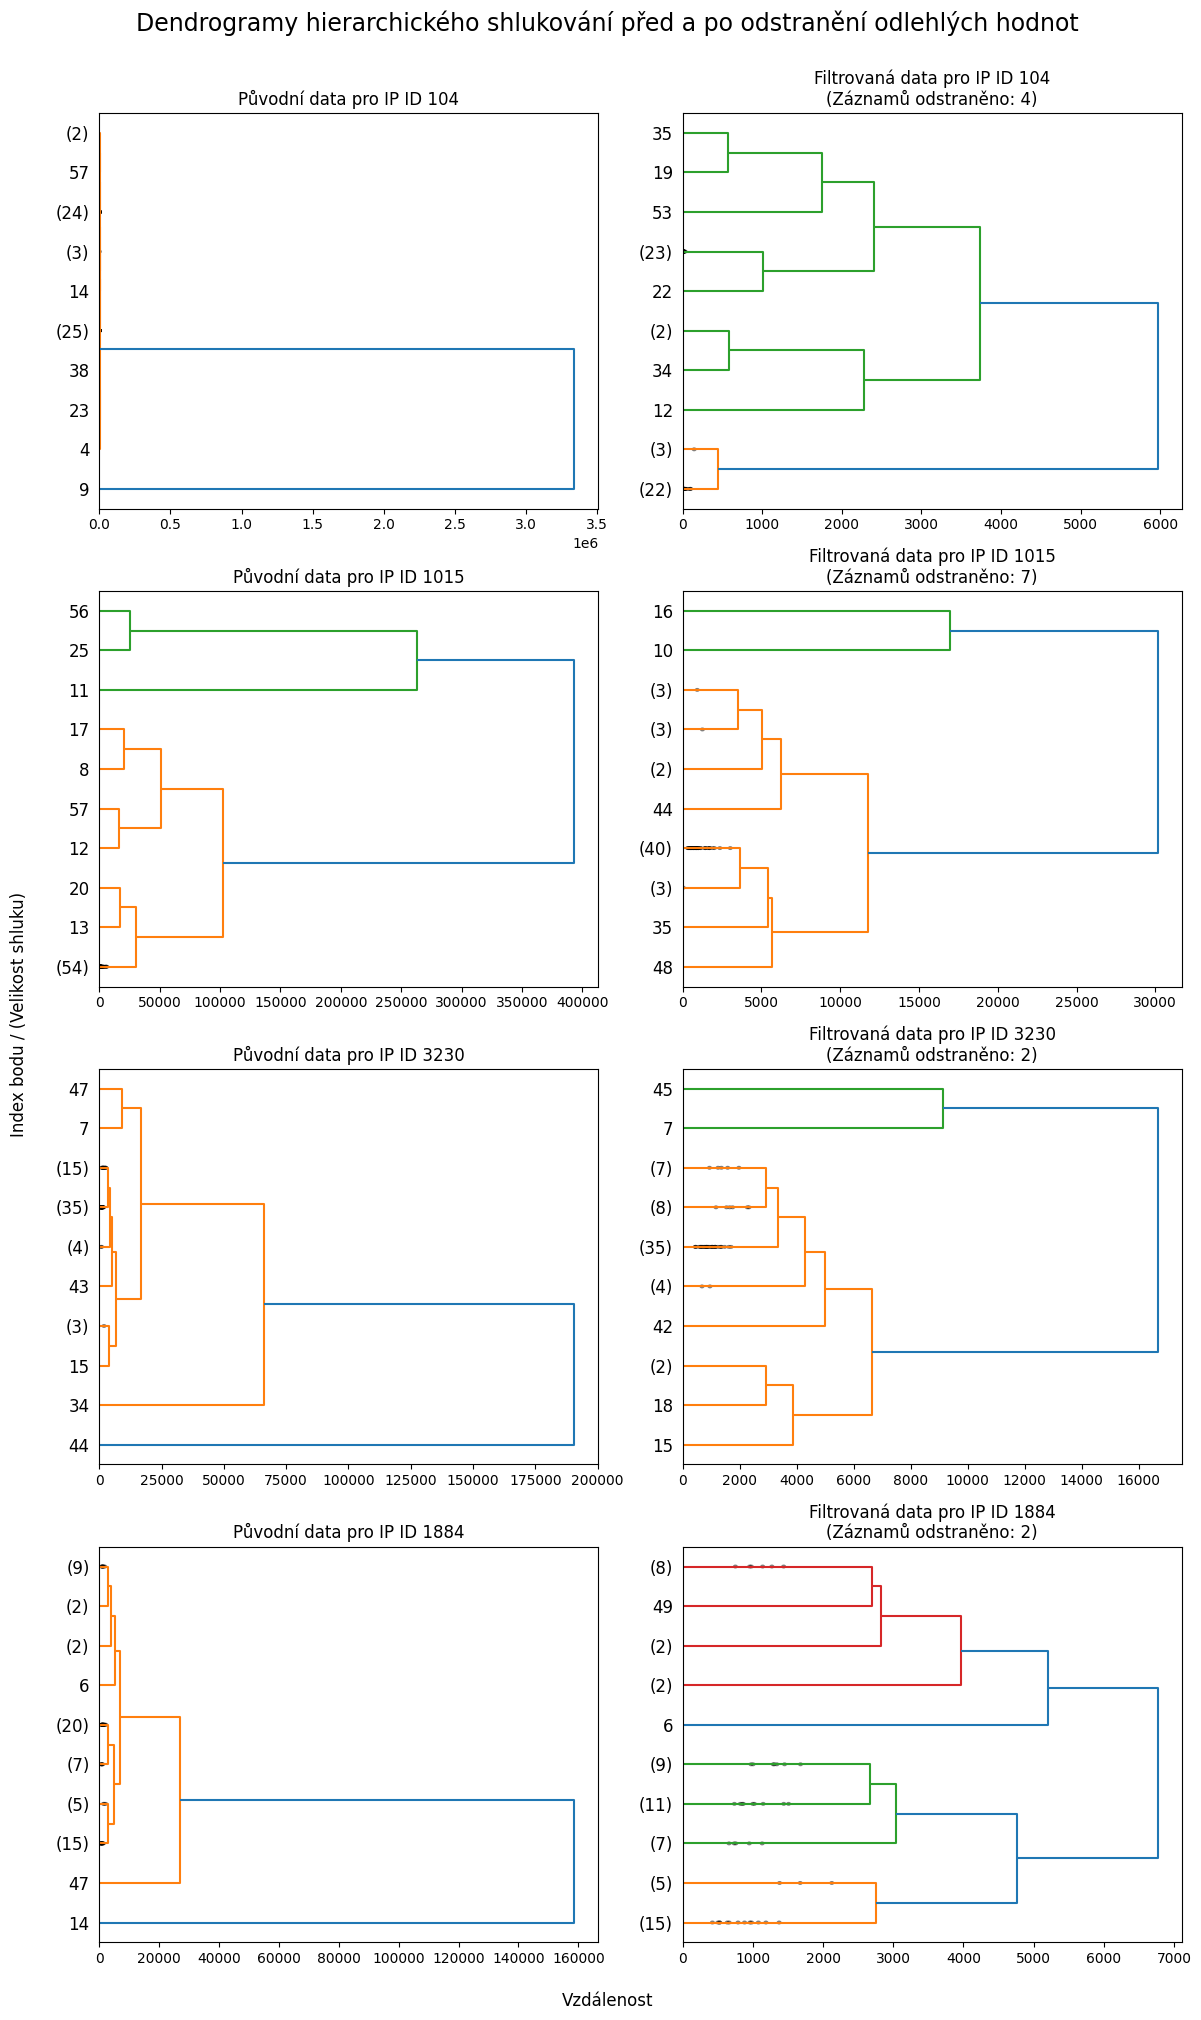

In [49]:
get_dendrograms(train_df, final_df, largest_diff, diff_dict)

In [50]:
# promíchání dat
final_df = final_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [51]:
train_df = final_df.copy()

In [52]:
print(train_df.shape, val_df.shape, test_df.shape)

(105777, 80) (23019, 80) (23020, 80)


Nakonec budou všechny datové množiny uloženy. V modelovací části je tak bude stačit načíst a pouze doupravit dle potřeby.

In [90]:
train_df.to_csv('train_test_data/train.csv', sep=';', header=True, index=False, encoding='utf-8')
val_df.to_csv('train_test_data/validation.csv', sep=';', header=True, index=False, encoding='utf-8')
test_df.to_csv('train_test_data/test.csv', sep=';', header=True, index=False, encoding='utf-8')

Tím je většina předzpracování dat hotová.
\
\
\
Bude dobré se pokusit data vizualizovat v prostoru. To ovšem nelze jen tak, jelikož použitá data mají aktuálně 80 příznaků, tedy mají 80. dimenzi. K vizualizaci může pomoct populární metoda t-SNE. Ta je více popsaná v samotném výstupu - textu bakalářské práce.

Poněvadž je v datech 1 727 unikátních IP adres, nebude ani vizuálně ani výpočetně efektivní chtít zobrazit všechny záznamy. Provedeme tak vizualizaci na náhodném výběru 30 IP adres, na kterém se již dříve zkoumala konzistence.

In [60]:
tmp_df = train_df[train_df['IP ID'].isin(random_sel)]
Xdata = tmp_df.drop('IP ID', axis=1)
Ydata = tmp_df['IP ID']

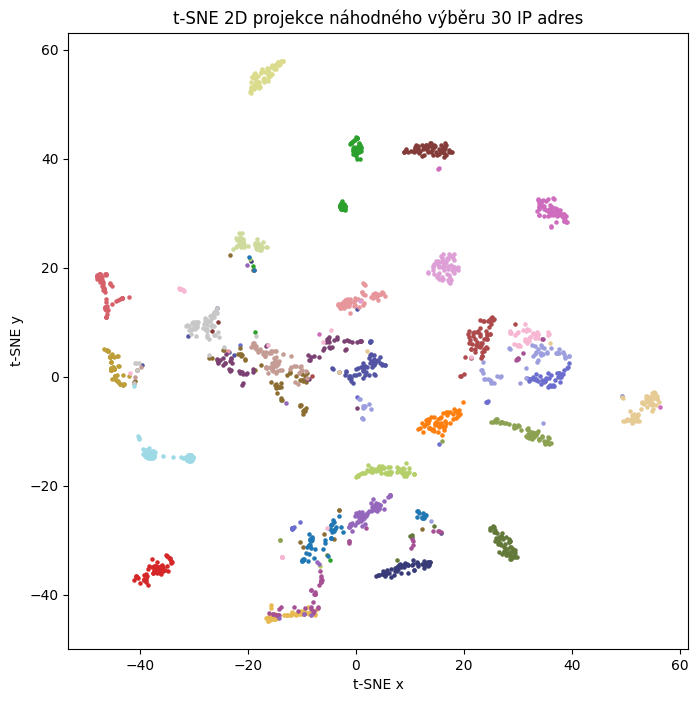

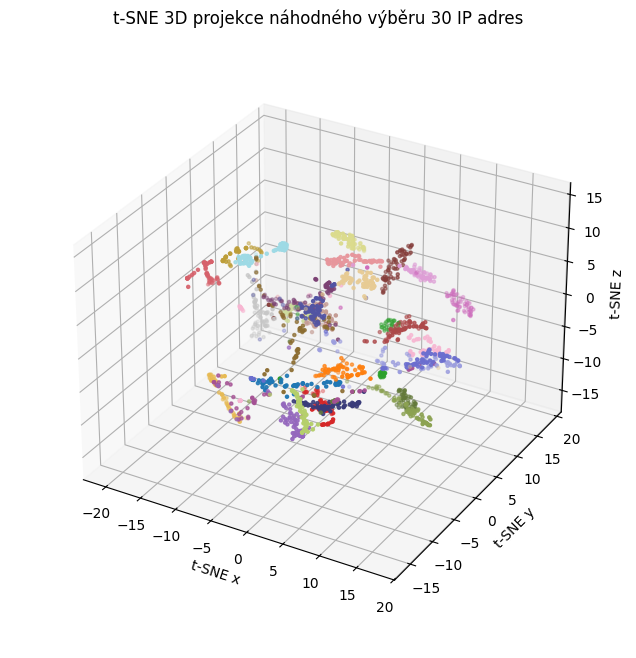

In [61]:
fig = plt.figure(figsize=(8, 8))

#t-SNE
tsne = TSNE(n_components=2)
Xtsne = tsne.fit_transform(Xdata)

labels_IDs_str = [str(i) for i in random_sel]

colors1 = cm.get_cmap('tab20b', 20)
colors2 = cm.get_cmap('tab20', 10)
colors = ListedColormap(np.concatenate([colors1.colors, colors2.colors]))

for i, label in enumerate(random_sel):
    Xtmp = Xtsne[Ydata == label]
    plt.scatter(Xtmp[:, 0], Xtmp[:, 1], color=colors(i), label=f"{labels_IDs_str[i]}", s=5)

plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.title('t-SNE 2D projekce náhodného výběru 30 IP adres')
# plt.legend()
plt.savefig('images/tsne/tsne2D.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close(fig)

#===================

fig = plt.figure(figsize=(8, 8))

tsne = TSNE(n_components=3)
Xtsne = tsne.fit_transform(Xdata)

ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(random_sel):
    Xtmp = Xtsne[Ydata == label]
    ax.scatter(Xtmp[:, 0], Xtmp[:, 1], Xtmp[:, 2], color=colors(i), label=f"{labels_IDs_str[i]}", s=5)
    
ax.set_xlabel('t-SNE x')
ax.set_ylabel('t-SNE y')
ax.set_zlabel('t-SNE z')
ax.set_title('t-SNE 3D projekce náhodného výběru 30 IP adres')
# ax.legend()
ax.set_box_aspect(aspect=None, zoom=0.9)
plt.savefig('images/tsne/tsne3D.png', dpi=500, bbox_inches='tight')
plt.show()
plt.close(fig)

Ze získané projekce se lze domnívat, že datové body jsou v prostoru rozmítěny v různých shlucích. Některé z nich by mohly být přímo samostatné IP adresy, jiné shluky zase IP adresy se stejným chováním (nevidíme všechny body v prostoru). Nicméně tato vizualizace dává dobrou naději, že úspěšnost identifikace IP adres by mohla být do jisté míry uspokojivá.
\
\
\
Jelikož použitou pokročilejší metodou na redukci dimenzionality bude PCA, je potřeba zjisit, jaký počet hlavních komponent je ten nejlepší. To lze zjistit za pomocí tzv. `scree plotu`, který ukáže, kolik hlavních komponent vysvětluje většinu rozptylu v datech. Příliš malý počet bude zbytečně ztrácet velké množství informace, příliš velký počet nebude efektivně redukovat dimenzi.

Jelikož se jedná o úlohu, kde se maximalizuje možný rozptyl, je nutné data nejdříve normalizovat, jinak bude PCA mnohem více protěžovat příznaky s velkým rozptylem.

In [57]:
Ytrain = train_df['IP ID']
Xtrain = train_df.drop('IP ID', axis=1)

In [58]:
standard_scaler = StandardScaler()
Xtrain_standard = standard_scaler.fit_transform(Xtrain)

In [59]:
pca = PCA()
Xtrain_PCA = pca.fit_transform(Xtrain_standard)

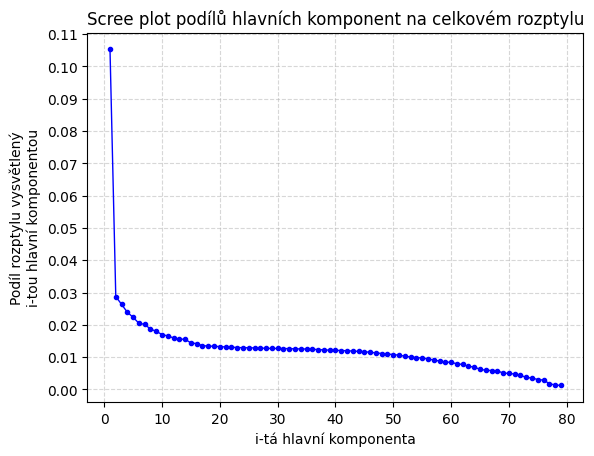

In [60]:
# Kód na scree plot převzat z https://www.statology.org/scree-plot-python/
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=3)
plt.title('Scree plot podílů hlavních komponent na celkovém rozptylu')
plt.xlabel('i-tá hlavní komponenta')
plt.ylabel('Podíl rozptylu vysvětlený\ni-tou hlavní komponentou')
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.01))
plt.grid(which='major', axis='y', linestyle='--')
plt.savefig('images/scree_plot/pca_scree_plot.png', dpi=500, bbox_inches='tight')
plt.show()

In [71]:
pca.explained_variance_ratio_[:50].sum()

np.float64(0.8148153185977324)

Tento výsledek je velmí překvapivý. Více jak desetina veškerého rozptylu je vysvětlena v první hlavní komponentě. Po 50. hlavní komponentě již klesá významnost pod 0,01. Pro práci s PCA tak bude zvolen počet hlavních komponent roven 50. Tento počet hlavních komponent pokrývá téměč 81,5 % veškerého rozptylu.

(Získaný poměr 50 hl. komponent s 81,5% pokrytím rozpytlu osobně považuji za dobrý. Přílišná redukce dimenze by již pravděpodobně byla problematická pro klasifikaci 1 727 tříd.)

________________

Kód pro vytvoření vzorové neoptimální a PCA projekce do textu BP -> kapitola 2, sekce 2.3.1.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


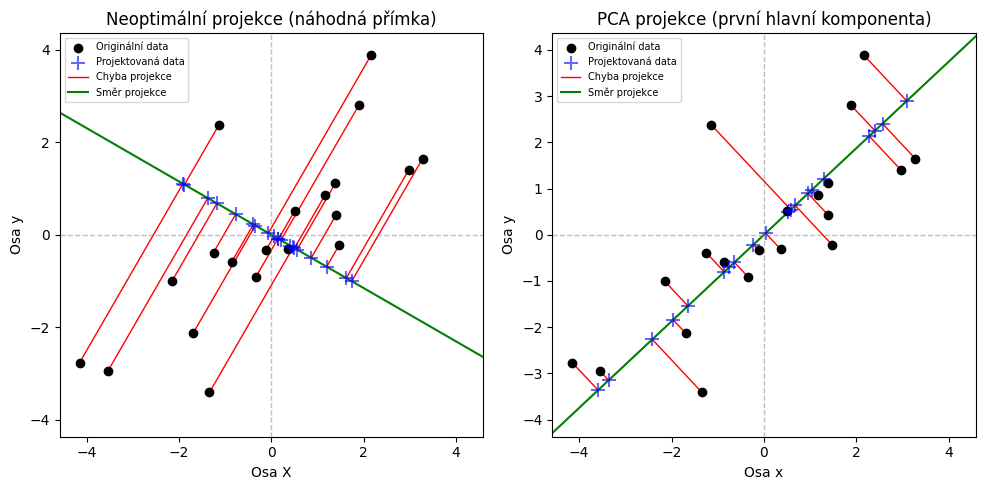

In [2]:
np.random.seed(51)
mean = [0, 0]
cov = [[4, 3], [3, 4]]
data = np.random.multivariate_normal(mean, cov, 20)
data = data - np.mean(data, axis=0) # ruční středování datasetu

# PCA analýza
pca = PCA(n_components=1)
data_pca = pca.fit_transform(data)
data_pca = pca.inverse_transform(data_pca)  # PCA body do 2D prostoru
np.sort(data_pca, axis=0)
np.sort(data_pca, axis=1)

x_diff = data_pca[-1][0] - data_pca[0][0]
y_diff = data_pca[-1][1] - data_pca[0][1]

low_x = data_pca[0][0]-x_diff*1000
low_y = data_pca[0][1]-y_diff*1000
high_x = data_pca[-1][0]+x_diff*1000
high_y = data_pca[-1][1]+y_diff*1000
xs = np.array([low_x, high_x])
ys = np.array([low_y, high_y])

angle = np.pi / -6
tmp_line = np.array([np.cos(angle), np.sin(angle)])
bad_projection = data.dot(tmp_line.reshape(-1, 1))
bad_projection = bad_projection * tmp_line

np.sort(bad_projection, axis=0)
np.sort(bad_projection, axis=1)

x_diff_bad = bad_projection[-1][0] - bad_projection[0][0]
y_diff_bad = bad_projection[-1][1] - bad_projection[0][1]

low_x_bad = bad_projection[0][0]-x_diff_bad*1000
low_y_bad = bad_projection[0][1]-y_diff_bad*1000
high_x_bad = bad_projection[-1][0]+x_diff_bad*1000
high_y_bad = bad_projection[-1][1]+y_diff_bad*1000
xs_bad = np.array([low_x_bad, high_x_bad])
ys_bad = np.array([low_y_bad, high_y_bad])

plt.figure(figsize=(10, 5))

# Náhodná projekce
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], alpha=1, color='black', label='Originální data')
plt.scatter(bad_projection[:, 0], bad_projection[:, 1], alpha=0.6, color='blue', marker='+', s=100, label='Projektovaná data')
for i in range(len(data)):
    plt.plot([data[i, 0], bad_projection[i, 0]], [data[i, 1], bad_projection[i, 1]],  color='red', label='Chyba projekce' if i == 0 else '', linewidth=1, zorder=0)
plt.plot(xs_bad, ys_bad, label='Směr projekce', color='green', zorder=0)
plt.axis('equal');
plt.xticks(np.arange(-10, 10, 2))
plt.yticks(np.arange(-10, 10, 2))
plt.title('Neoptimální projekce (náhodná přímka)')
plt.legend(loc='upper left', fontsize=7)
plt.ylim(-3, 3);
plt.xlim(-4, 4);
plt.xlabel('Osa X')
plt.ylabel('Osa y')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# PCA
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], alpha=1, color='black', label='Originální data')
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.6, color='blue', marker='+', s=100, label='Projektovaná data')
for i in range(len(data)):
    plt.plot([data[i, 0], data_pca[i, 0]], [data[i, 1], data_pca[i, 1]], color='red', label='Chyba projekce' if i == 0 else '', linewidth=1, zorder=0)
plt.plot(xs, ys, label='Směr projekce', color='green', zorder=0)
plt.axis('equal');
plt.title('PCA projekce (první hlavní komponenta)')
plt.legend(loc='upper left', fontsize=7)
plt.ylim(-3, 3);
plt.xlim(-4, 4);
plt.xlabel('Osa x')
plt.ylabel('Osa y')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('images/scree_plot/pca_projection.png', dpi=750, bbox_inches='tight')
plt.show()